# Loan Regression & Classification

## Installs, Imports & Load Data

In [2]:
# Install, import packages and load data
!pip install imblearn --user
!pip install catboost --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn as il
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from statsmodels.graphics.correlation import plot_corr
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

%matplotlib inline

df = pd.read_csv('Personal_Loans.csv')

## Explore & Clean Data

In [3]:
# Check dataset
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,Gender,Area,Personal Loan,Loan Size
0,26,2,60,2,3.0,Undergrad,132,0,0,0,Male,Alameda,1,15
1,26,0,83,3,3.9,Postgrad,0,0,0,1,Female,Ventura,1,30
2,26,0,129,3,0.7,Postgrad,0,0,0,0,Male,Los Angeles,1,33
3,26,0,132,3,6.5,Professional,0,0,0,0,Female,Orange,1,40
4,26,2,132,2,2.4,Professional,0,0,0,0,Male,Alameda,1,35


In [4]:
# Check for nulls and datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 14 columns):
Age                   4846 non-null int64
Experience            4846 non-null int64
Income                4846 non-null int64
Family                4846 non-null int64
CCAvg                 4846 non-null float64
Education             4846 non-null object
Mortgage              4846 non-null int64
Securities Account    4846 non-null int64
CD Account            4846 non-null int64
Online                4846 non-null int64
Gender                4846 non-null object
Area                  4846 non-null object
Personal Loan         4846 non-null int64
Loan Size             4846 non-null int64
dtypes: float64(1), int64(10), object(3)
memory usage: 530.2+ KB


In [5]:
# Check for need to standardize data and features, labels correct
df.describe()

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities Account,CD Account,Online,Personal Loan,Loan Size
count,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000
mean,45.388981,20.169212,73.995047,2.395378,1.942984,56.936236,0.104003,0.060050,0.598019,0.097194,3.229880
std,11.423346,11.363324,46.017608,1.143967,1.745590,102.061477,0.305296,0.237603,0.490349,0.296252,10.303425
min,23.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,1.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,2.000000,1.600000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,55.000000,30.000000,98.000000,3.000000,2.500000,101.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,67.000000,43.000000,224.000000,4.000000,10.000000,635.000000,1.000000,1.000000,1.000000,1.000000,50.000000


In [6]:
# Remove Duplicates
df[df.duplicated(keep = False)]
df = df.drop([1578], axis = 0)

In [7]:
# Check Loan Size is 0 when Personal Loan not granted
len(df[(df['Personal Loan'] == 0) & (df['Loan Size'] > 0)])

0

## Resample & Encode Dummy Variables

In [8]:
# Split by Personal Loan label
loan = df[df['Personal Loan'] == 1]
no_loan = df[df['Personal Loan'] == 0]

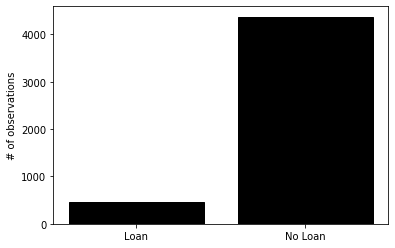

In [9]:
# Check class balance
labels = df['Personal Loan'].unique()
heights = [len(no_loan), len(loan)]
plt.bar(labels, heights, color = 'black', edgecolor = 'k')
plt.xticks(labels, ['No Loan', 'Loan'])
plt.ylabel("# of observations")
plt.show()

In [10]:
print('Percentage of No Loan entries in the dataset: ' + str(round(len(no_loan)/(len(df)) * 100, 2)) + '%')
print('Number of Loan entries in the dataset: ' + str(len(loan)))
print('Number of No Loan entries in the dataset: ' + str(len(no_loan)))

Percentage of No Loan entries in the dataset: 90.28%
Number of Loan entries in the dataset: 471
Number of No Loan entries in the dataset: 4374


In [11]:
# Split classification label for resampling
X_c = df.drop(['Personal Loan'], axis = 1)
y_c = df['Personal Loan']

In [12]:
# Encode dummy variables so no categorical data for resampling
X_c = pd.get_dummies(X_c, drop_first = True)
X_c.columns = [col.replace(" ","_") for col in X_c.columns]

In [13]:
# Encode dummy variables for regression
X_r = df.loc[df['Personal Loan'] == 1]
y_r = X_r['Loan Size']
X_r = X_r.drop(['Loan Size'], axis = 1)
X_r = pd.get_dummies(X_r, drop_first = True)
X_r.columns = [col.replace(" ","_") for col in X_r.columns]

In [14]:
# Check number of new columns
X_r.shape

(471, 41)

In [15]:
# Check number of new columns
X_c.shape

(4845, 50)

In [16]:
# Number of samples to use
print(round(len(no_loan) / 2))

2187


In [17]:
pipeline = make_pipeline(SMOTE(sampling_strategy={1: 2187}), NearMiss(sampling_strategy={0: 2187}))
X_res, y_res = pipeline.fit_resample(X_c, y_c)

In [18]:
# Check number of class balance again
y_res.value_counts()

1    2187
0    2187
Name: Personal Loan, dtype: int64

## Split Labels & Features

In [19]:
# Regression labels
y_r = y_r

# Classification labels
y_c = y_res

# Features
X_res_r = X_r.drop(['Personal_Loan'], axis = 1)
X_res_c = X_res.drop(['Loan_Size'], axis = 1)

In [20]:
X_res_r.shape
X_res_c.shape

(4374, 49)

## Check Correlations & Remove Multicollinearity

In [21]:
#Check correlations for regression
X_res_r.corr()

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,Education_Professional,...,Area_San_Mateo,Area_Santa_Barbara,Area_Santa_Clara,Area_Santa_Cruz,Area_Shasta,Area_Solano,Area_Sonoma,Area_Stanislaus,Area_Ventura,Area_Yolo
Age,1.000000,0.994515,0.015225,-0.000511,-0.001101,0.032283,-0.024383,0.058700,0.032229,0.003841,...,-0.010221,-0.013636,0.018168,-0.003689,0.056028,-0.008313,-0.006905,-0.064364,-0.002742,0.020305
Experience,0.994515,1.000000,0.009290,0.008815,-0.016679,0.027737,-0.020221,0.064950,0.034709,-0.004923,...,-0.008797,-0.016887,0.008422,0.000090,0.059995,-0.009162,-0.008093,-0.063715,0.000113,0.025643
Income,0.015225,0.009290,1.000000,-0.024424,0.225125,0.185415,-0.046466,0.076141,0.074409,0.075741,...,0.041727,0.011555,0.058393,-0.020837,0.075340,-0.067657,-0.008274,0.054066,-0.015916,-0.016307
Family,-0.000511,0.008815,-0.024424,1.000000,0.007318,0.065640,-0.097798,-0.001103,-0.036258,-0.166264,...,0.038507,-0.021532,-0.102810,-0.004189,0.028135,0.052141,0.022887,-0.066773,-0.059468,0.016631
CCAvg,-0.001101,-0.016679,0.225125,0.007318,1.000000,0.026942,0.021183,0.036788,-0.019209,0.045713,...,-0.068928,-0.015515,-0.025163,0.009131,0.138691,0.005043,0.062233,-0.004428,0.097795,0.017944
Mortgage,0.032283,0.027737,0.185415,0.065640,0.026942,1.000000,-0.026032,0.091658,0.076362,0.008197,...,-0.040652,0.107640,-0.023643,-0.023965,0.078169,-0.050456,0.048195,-0.029069,-0.036239,0.068001
Securities_Account,-0.024383,-0.020221,-0.046466,-0.097798,0.021183,-0.026032,1.000000,0.469349,0.054820,-0.029854,...,-0.011241,0.026419,-0.002559,-0.046480,0.050326,0.050326,0.128594,-0.017455,-0.016050,-0.000105
CD_Account,0.058700,0.064950,0.076141,-0.001103,0.036788,0.091658,0.469349,1.000000,0.375201,-0.065443,...,0.004357,-0.004752,-0.050905,0.038557,0.067291,0.008270,0.053602,-0.029238,-0.035842,-0.046983
Online,0.032229,0.034709,0.074409,-0.036258,-0.019209,0.076362,0.054820,0.375201,1.000000,-0.040918,...,-0.002177,-0.019557,-0.039967,-0.009001,0.009746,0.009746,-0.024939,0.037098,-0.019557,-0.028859
Education_Professional,0.003841,-0.004923,0.075741,-0.166264,0.045713,0.008197,-0.029854,-0.065443,-0.040918,1.000000,...,0.050925,-0.020384,0.008205,-0.000075,0.038468,-0.069380,-0.021929,0.053229,-0.020384,-0.014309


In [22]:
#Check correlations for classification
X_res_c.corr()

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,Education_Professional,...,Area_Santa_Cruz,Area_Shasta,Area_Siskiyou,Area_Solano,Area_Sonoma,Area_Stanislaus,Area_Trinity,Area_Tuolumne,Area_Ventura,Area_Yolo
Age,1.000000,0.992460,0.051093,-0.051064,0.022498,-0.003804,-0.030756,0.017432,-0.005730,0.040770,...,-0.013554,-0.002861,-0.002694,0.006547,0.007904,-0.016887,0.000036,-0.012843,0.016005,-0.021885
Experience,0.992460,1.000000,0.053991,-0.052254,0.018451,-0.007356,-0.028984,0.022488,-0.003089,0.024113,...,-0.010646,-0.001152,-0.002240,0.006317,0.007341,-0.016455,-0.000543,-0.012657,0.015617,-0.022806
Income,0.051093,0.053991,1.000000,-0.153245,0.522266,0.259461,-0.095293,0.147341,-0.088480,-0.107297,...,-0.040676,-0.007607,-0.028211,-0.030721,-0.027064,-0.005799,-0.010295,-0.012390,-0.053951,-0.074373
Family,-0.051064,-0.052254,-0.153245,1.000000,-0.068676,-0.009166,0.021354,-0.001244,-0.005640,0.022878,...,0.015079,0.019881,-0.016004,0.003494,0.024940,-0.001825,0.003757,0.024065,-0.007633,0.031571
CCAvg,0.022498,0.018451,0.522266,-0.068676,1.000000,0.109143,-0.033299,0.102368,-0.092995,-0.082332,...,-0.025881,0.007610,-0.021082,-0.007580,0.013009,0.012077,-0.008905,-0.018433,-0.044216,-0.042435
Mortgage,-0.003804,-0.007356,0.259461,-0.009166,0.109143,1.000000,-0.034401,0.096310,0.004594,-0.025163,...,-0.003651,0.003102,0.000152,-0.008465,0.003420,-0.016778,-0.011861,0.025981,-0.018984,-0.006673
Securities_Account,-0.030756,-0.028984,-0.095293,0.021354,-0.033299,-0.034401,1.000000,0.291627,0.056561,0.010480,...,0.007830,0.046662,-0.007210,0.027729,0.027729,-0.008327,-0.005887,-0.004162,-0.002251,0.009329
CD_Account,0.017432,0.022488,0.147341,-0.001244,0.102368,0.096310,0.291627,1.000000,0.226064,0.002275,...,0.015819,0.044037,-0.007521,-0.003114,0.025444,-0.008685,-0.006140,-0.004341,0.002617,-0.007727
Online,-0.005730,-0.003089,-0.088480,-0.005640,-0.092995,0.004594,0.056561,0.226064,1.000000,-0.000723,...,-0.000196,0.015032,0.026138,0.007436,-0.000139,-0.000069,-0.000049,0.015088,0.040670,0.023915
Education_Professional,0.040770,0.024113,-0.107297,0.022878,-0.082332,-0.025163,0.010480,0.002275,-0.000723,1.000000,...,0.015944,0.010668,0.006155,0.002307,-0.006639,0.019020,0.013446,0.027369,0.044829,0.019042


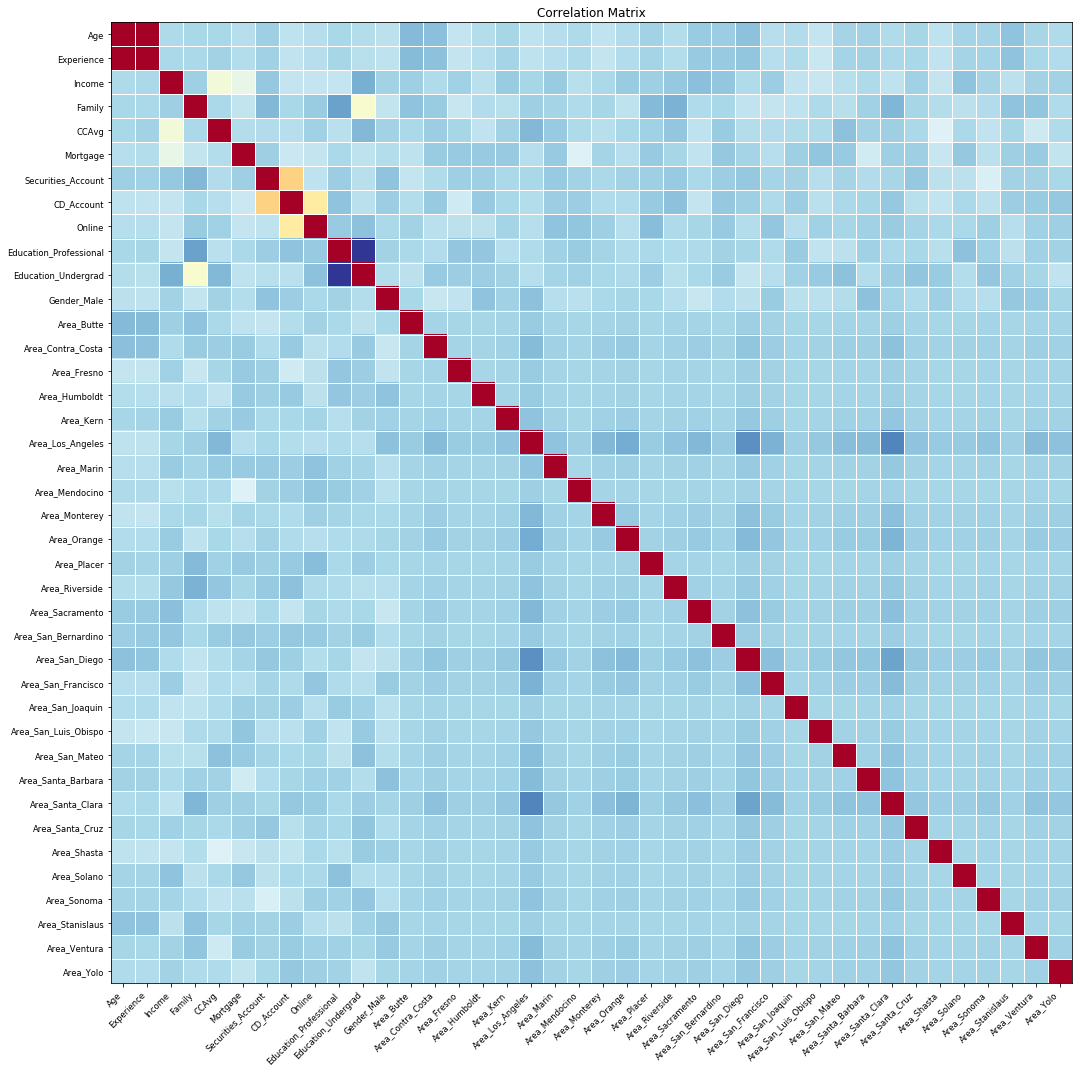

In [23]:
# Correlation matrix for regression
fig = plt.figure(figsize = (15, 15));
ax = fig.add_subplot(111);
plot_corr(X_res_r.corr(), xnames = X_res_r.corr().columns, ax = ax);

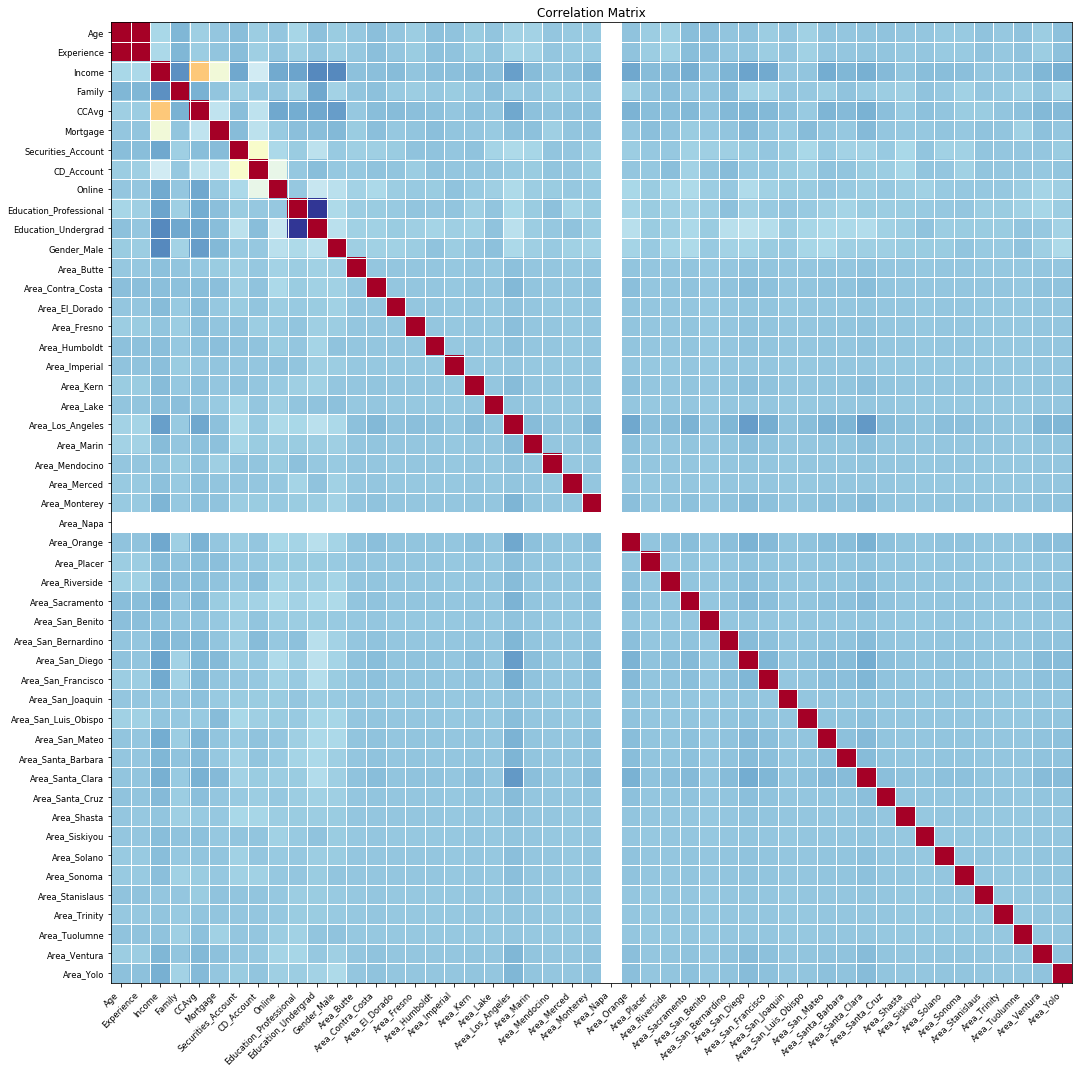

In [24]:
# Correlation matrix for classification
fig = plt.figure(figsize = (15, 15));
ax = fig.add_subplot(111);
plot_corr(X_res_c.corr(), xnames = X_res_c.corr().columns, ax = ax);

In [25]:
# Drop high correlations
def drop_high_corr(data):
    columns = np.full((data.corr().shape[0],), True, dtype = bool)
    for i in range(data.corr().shape[0]):
        for j in range(i + 1, data.corr().shape[0]):
            if data.corr().iloc[i,j] >= 0.8:
                if columns[j]:
                    columns[j] = False
    selected_columns = data.columns[columns]
    return data[selected_columns]

X_res_r = drop_high_corr(X_res_r)
X_res_c = drop_high_corr(X_res_c)

In [26]:
# Check remaining columns
X_res_r.shape
X_res_r.columns

Index(['Age', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account',
       'CD_Account', 'Online', 'Education_Professional', 'Education_Undergrad',
       'Gender_Male', 'Area_Butte', 'Area_Contra_Costa', 'Area_Fresno',
       'Area_Humboldt', 'Area_Kern', 'Area_Los_Angeles', 'Area_Marin',
       'Area_Mendocino', 'Area_Monterey', 'Area_Orange', 'Area_Placer',
       'Area_Riverside', 'Area_Sacramento', 'Area_San_Bernardino',
       'Area_San_Diego', 'Area_San_Francisco', 'Area_San_Joaquin',
       'Area_San_Luis_Obispo', 'Area_San_Mateo', 'Area_Santa_Barbara',
       'Area_Santa_Clara', 'Area_Santa_Cruz', 'Area_Shasta', 'Area_Solano',
       'Area_Sonoma', 'Area_Stanislaus', 'Area_Ventura', 'Area_Yolo'],
      dtype='object')

In [27]:
# Check remaining columns
X_res_c.shape
X_res_c.columns

Index(['Age', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account',
       'CD_Account', 'Online', 'Education_Professional', 'Education_Undergrad',
       'Gender_Male', 'Area_Butte', 'Area_Contra_Costa', 'Area_El_Dorado',
       'Area_Fresno', 'Area_Humboldt', 'Area_Imperial', 'Area_Kern',
       'Area_Lake', 'Area_Los_Angeles', 'Area_Marin', 'Area_Mendocino',
       'Area_Merced', 'Area_Monterey', 'Area_Napa', 'Area_Orange',
       'Area_Placer', 'Area_Riverside', 'Area_Sacramento', 'Area_San_Benito',
       'Area_San_Bernardino', 'Area_San_Diego', 'Area_San_Francisco',
       'Area_San_Joaquin', 'Area_San_Luis_Obispo', 'Area_San_Mateo',
       'Area_Santa_Barbara', 'Area_Santa_Clara', 'Area_Santa_Cruz',
       'Area_Shasta', 'Area_Siskiyou', 'Area_Solano', 'Area_Sonoma',
       'Area_Stanislaus', 'Area_Trinity', 'Area_Tuolumne', 'Area_Ventura',
       'Area_Yolo'],
      dtype='object')

## Standardize Data

In [28]:
# Standardize data and reduce effect of outliers
scaler = RobustScaler()

X_scaled_r = scaler.fit_transform(X_res_r)
X_standardize_r = pd.DataFrame(X_scaled_r, columns = X_res_r.columns)

X_scaled_c = scaler.fit_transform(X_res_c)
X_standardize_c = pd.DataFrame(X_scaled_c, columns = X_res_c.columns)

In [29]:
X_standardize_r.head()

,Age,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,Education_Professional,Education_Undergrad,...,Area_San_Mateo,Area_Santa_Barbara,Area_Santa_Clara,Area_Santa_Cruz,Area_Shasta,Area_Solano,Area_Sonoma,Area_Stanislaus,Area_Ventura,Area_Yolo
0,-0.95,-1.66,-0.5,-0.290909,0.683938,0.0,0.0,-1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.95,-1.20,0.0,0.036364,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.95,-0.28,0.0,-1.127273,0.000000,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.95,-0.22,0.0,0.981818,0.000000,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.95,-0.22,-0.5,-0.509091,0.000000,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
X_standardize_r.head()

,Age,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,Education_Professional,Education_Undergrad,...,Area_San_Mateo,Area_Santa_Barbara,Area_Santa_Clara,Area_Santa_Cruz,Area_Shasta,Area_Solano,Area_Sonoma,Area_Stanislaus,Area_Ventura,Area_Yolo
0,-0.95,-1.66,-0.5,-0.290909,0.683938,0.0,0.0,-1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.95,-1.20,0.0,0.036364,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.95,-0.28,0.0,-1.127273,0.000000,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.95,-0.22,0.0,0.981818,0.000000,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.95,-0.22,-0.5,-0.509091,0.000000,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Regression train/test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_standardize_r, y_r, test_size = 0.25, random_state = 46)
print(X_train_r.shape)
print(X_test_r.shape)
print(y_train_r.shape)
print(y_test_r.shape)
# Classification train/test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_standardize_c, y_c, test_size = 0.25, random_state = 46)
print(X_train_c.shape)
print(X_test_c.shape)
print(y_train_c.shape)
print(y_test_c.shape)

(353, 39)
(118, 39)
(353,)
(118,)
(3280, 48)
(1094, 48)
(3280,)
(1094,)


## Build & Test Models

In [32]:
# Fit and evaluate all regression models
def reg_fit_and_evaluate(X_train, X_test, y_train, y_test, names, models):
    model_name = []
    model_rmse = []
    model_rsq = []
    for name, model in zip(names, models):
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        model_name.append(name)
        model_rmse.append(mean_squared_error(y_test, prediction, squared = False))
        model_rsq.append(r2_score(y_test, prediction))
    results = {'Model_Name': model_name, 'RMSE': model_rmse, 'R-Squared': model_rsq}
    results = pd.DataFrame(results).sort_values('RMSE')
    return results

# Fit and evaluate all classifier models
def cla_fit_and_evaluate(X_train, X_test, y_train, y_test, names, models):
    model_name = []
    model_accuracy = []
    model_precision = []
    model_recall = []
    model_f1 = []
    for name, model in zip(names, models):
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        model_name.append(name)
        model_accuracy.append(accuracy_score(y_test, prediction))
        model_precision.append(precision_score(y_test, prediction))
        model_recall.append(recall_score(y_test, prediction))
        model_f1.append(f1_score(y_test, prediction))
    results = {'Model_Name': model_name, 'Accuracy': model_accuracy, 'Precision': model_precision, 'Recall': model_recall, 'F1': model_f1}
    results = pd.DataFrame(results).sort_values('Accuracy')
    return results

In [33]:
# Fit and evaluate all regression models with K fold
def reg_fit_and_evaluate_kf(names, models):
    model_name = []
    model_rmse = []
    model_rsq = []
    avg_rmse = []
    avg_rsq = []
    for name, model in zip(names, models):
        folds = KFold(n_splits = 10, shuffle = True, random_state = 46)
        for train_index, test_index in folds.split(X_standardize_r):
            X_train, X_test = X_standardize_r.iloc[train_index], X_standardize_r.iloc[test_index]
            y_train, y_test = y_r.iloc[train_index], y_r.iloc[test_index]
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            model_name.append(name)
            model_rmse.append(mean_squared_error(y_test, prediction, squared = False))
            model_rsq.append(r2_score(y_test, prediction))
        avg_rmse.append(np.mean(model_rmse))
        avg_rsq.append(np.mean(model_rsq))
    results = {'Model_Name': names_r, 'RMSE': avg_rmse, 'R-Squared': avg_rsq}
    results = pd.DataFrame(results).sort_values('RMSE')
    return results

# Fit and evaluate all classifier models with K fold
def cla_fit_and_evaluate_kf(names, models):
    model_name = []
    model_accuracy = []
    model_precision = []
    model_recall = []
    model_f1 = []
    avg_accuracy = []
    avg_precision = []
    avg_recall = []
    avg_f1 = []
    for name, model in zip(names, models):
        folds = KFold(n_splits = 10, shuffle = True, random_state = 46)
        for train_index, test_index in folds.split(X_standardize_c):
            X_train, X_test = X_standardize_c.iloc[train_index], X_standardize_c.iloc[test_index]
            y_train, y_test = y_c.iloc[train_index], y_c.iloc[test_index]
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            model_name.append(name)
            model_accuracy.append(accuracy_score(y_test, prediction))
            model_precision.append(precision_score(y_test, prediction))
            model_recall.append(recall_score(y_test, prediction))
            model_f1.append(f1_score(y_test, prediction))
        avg_accuracy.append(np.mean(model_accuracy))
        avg_precision.append(np.mean(model_precision))
        avg_recall.append(np.mean(model_recall))
        avg_f1.append(np.mean(model_f1))
    results = {'Model_Name': names_c, 'Accuracy': avg_accuracy, 'Precision': avg_precision, 'Recall': avg_recall, 'F1': avg_f1}
    results = pd.DataFrame(results).sort_values('Accuracy')
    return results

In [34]:
# Instantiate regression models
names_r = ['Linear Regression', 'KNR', 'SVR', 'DTR', 'RFR', 'CatBoost']
models_r = [LinearRegression(), KNeighborsRegressor(3), SVR(kernel = 'rbf', gamma = 'auto'), DecisionTreeRegressor(max_depth = 5, random_state = 46),
    RandomForestRegressor(max_depth = 5, n_estimators = 10, max_features = 1, random_state = 46), CatBoostRegressor()]

# Instantiate classification models
names_c = ['Logistic Regression', 'KNC', 'SVC', 'DTC', 'RFC', 'AdaBoost']
models_c = [LogisticRegression(random_state = 46), KNeighborsClassifier(3), SVC(kernel = "linear", C = 0.025), DecisionTreeClassifier(max_depth = 5, random_state = 46),
    RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1, random_state = 46), AdaBoostClassifier(random_state = 46)]

In [242]:
# Display metrics for regression models
print(reg_fit_and_evaluate(X_train_r, X_test_r, y_train_r, y_test_r, names_r, models_r))

Learning rate set to 0.032427
0:	learn: 9.4052101	total: 1.1ms	remaining: 1.1s
1:	learn: 9.2241317	total: 2.02ms	remaining: 1.01s
2:	learn: 9.0385105	total: 3.05ms	remaining: 1.01s
3:	learn: 8.8477811	total: 4.01ms	remaining: 999ms
4:	learn: 8.6760345	total: 4.89ms	remaining: 973ms
5:	learn: 8.5052761	total: 5.7ms	remaining: 944ms
6:	learn: 8.3523857	total: 6.65ms	remaining: 944ms
7:	learn: 8.1963616	total: 7.5ms	remaining: 929ms
8:	learn: 8.0178250	total: 8.46ms	remaining: 932ms
9:	learn: 7.8650200	total: 9.36ms	remaining: 926ms
10:	learn: 7.7302803	total: 10.2ms	remaining: 919ms
11:	learn: 7.6066016	total: 11.1ms	remaining: 912ms
12:	learn: 7.4596371	total: 12.1ms	remaining: 919ms
13:	learn: 7.3240811	total: 12.9ms	remaining: 911ms
14:	learn: 7.2026416	total: 13.7ms	remaining: 903ms
15:	learn: 7.0733071	total: 14.6ms	remaining: 898ms
16:	learn: 6.9402911	total: 15.5ms	remaining: 897ms
17:	learn: 6.8140155	total: 16.4ms	remaining: 894ms
18:	learn: 6.7117485	total: 17.5ms	remaining: 90

162:	learn: 2.6559247	total: 145ms	remaining: 742ms
163:	learn: 2.6508192	total: 145ms	remaining: 741ms
164:	learn: 2.6453726	total: 146ms	remaining: 740ms
165:	learn: 2.6379080	total: 147ms	remaining: 739ms
166:	learn: 2.6305761	total: 148ms	remaining: 738ms
167:	learn: 2.6241015	total: 149ms	remaining: 737ms
168:	learn: 2.6179945	total: 150ms	remaining: 736ms
169:	learn: 2.6100475	total: 150ms	remaining: 734ms
170:	learn: 2.6053198	total: 151ms	remaining: 733ms
171:	learn: 2.6000323	total: 152ms	remaining: 732ms
172:	learn: 2.5948429	total: 153ms	remaining: 730ms
173:	learn: 2.5890727	total: 154ms	remaining: 729ms
174:	learn: 2.5826500	total: 154ms	remaining: 727ms
175:	learn: 2.5769798	total: 155ms	remaining: 726ms
176:	learn: 2.5732620	total: 156ms	remaining: 725ms
177:	learn: 2.5685163	total: 157ms	remaining: 724ms
178:	learn: 2.5642496	total: 158ms	remaining: 723ms
179:	learn: 2.5564877	total: 158ms	remaining: 722ms
180:	learn: 2.5521825	total: 159ms	remaining: 720ms
181:	learn: 

347:	learn: 1.9591388	total: 298ms	remaining: 558ms
348:	learn: 1.9576366	total: 299ms	remaining: 558ms
349:	learn: 1.9523935	total: 300ms	remaining: 557ms
350:	learn: 1.9481422	total: 301ms	remaining: 556ms
351:	learn: 1.9451324	total: 302ms	remaining: 555ms
352:	learn: 1.9420533	total: 303ms	remaining: 555ms
353:	learn: 1.9398112	total: 303ms	remaining: 554ms
354:	learn: 1.9373287	total: 304ms	remaining: 553ms
355:	learn: 1.9335678	total: 305ms	remaining: 552ms
356:	learn: 1.9294439	total: 306ms	remaining: 551ms
357:	learn: 1.9237144	total: 307ms	remaining: 550ms
358:	learn: 1.9180305	total: 308ms	remaining: 549ms
359:	learn: 1.9125466	total: 309ms	remaining: 548ms
360:	learn: 1.9076486	total: 309ms	remaining: 548ms
361:	learn: 1.9045238	total: 310ms	remaining: 547ms
362:	learn: 1.9011451	total: 311ms	remaining: 547ms
363:	learn: 1.8987651	total: 312ms	remaining: 546ms
364:	learn: 1.8978351	total: 313ms	remaining: 545ms
365:	learn: 1.8953221	total: 314ms	remaining: 544ms
366:	learn: 

525:	learn: 1.5436401	total: 450ms	remaining: 406ms
526:	learn: 1.5418184	total: 451ms	remaining: 405ms
527:	learn: 1.5382362	total: 452ms	remaining: 404ms
528:	learn: 1.5372961	total: 453ms	remaining: 403ms
529:	learn: 1.5354000	total: 454ms	remaining: 402ms
530:	learn: 1.5340479	total: 455ms	remaining: 401ms
531:	learn: 1.5312615	total: 455ms	remaining: 401ms
532:	learn: 1.5296951	total: 456ms	remaining: 400ms
533:	learn: 1.5289884	total: 457ms	remaining: 399ms
534:	learn: 1.5287101	total: 458ms	remaining: 398ms
535:	learn: 1.5280045	total: 459ms	remaining: 397ms
536:	learn: 1.5263239	total: 460ms	remaining: 396ms
537:	learn: 1.5242411	total: 461ms	remaining: 396ms
538:	learn: 1.5222595	total: 461ms	remaining: 395ms
539:	learn: 1.5204145	total: 462ms	remaining: 394ms
540:	learn: 1.5177582	total: 463ms	remaining: 393ms
541:	learn: 1.5175256	total: 464ms	remaining: 392ms
542:	learn: 1.5167217	total: 465ms	remaining: 391ms
543:	learn: 1.5144720	total: 466ms	remaining: 390ms
544:	learn: 

706:	learn: 1.2558173	total: 604ms	remaining: 250ms
707:	learn: 1.2544003	total: 605ms	remaining: 250ms
708:	learn: 1.2533996	total: 606ms	remaining: 249ms
709:	learn: 1.2514562	total: 607ms	remaining: 248ms
710:	learn: 1.2507388	total: 608ms	remaining: 247ms
711:	learn: 1.2503008	total: 609ms	remaining: 246ms
712:	learn: 1.2492363	total: 609ms	remaining: 245ms
713:	learn: 1.2476686	total: 610ms	remaining: 244ms
714:	learn: 1.2464251	total: 611ms	remaining: 244ms
715:	learn: 1.2462793	total: 612ms	remaining: 243ms
716:	learn: 1.2429688	total: 613ms	remaining: 242ms
717:	learn: 1.2411838	total: 614ms	remaining: 241ms
718:	learn: 1.2384341	total: 615ms	remaining: 240ms
719:	learn: 1.2382366	total: 616ms	remaining: 240ms
720:	learn: 1.2380382	total: 617ms	remaining: 239ms
721:	learn: 1.2372201	total: 618ms	remaining: 238ms
722:	learn: 1.2366268	total: 619ms	remaining: 237ms
723:	learn: 1.2359323	total: 619ms	remaining: 236ms
724:	learn: 1.2337809	total: 620ms	remaining: 235ms
725:	learn: 

885:	learn: 1.0382044	total: 758ms	remaining: 97.5ms
886:	learn: 1.0359573	total: 759ms	remaining: 96.7ms
887:	learn: 1.0346556	total: 760ms	remaining: 95.8ms
888:	learn: 1.0338907	total: 760ms	remaining: 94.9ms
889:	learn: 1.0325012	total: 761ms	remaining: 94.1ms
890:	learn: 1.0324079	total: 762ms	remaining: 93.2ms
891:	learn: 1.0310339	total: 763ms	remaining: 92.4ms
892:	learn: 1.0297938	total: 764ms	remaining: 91.5ms
893:	learn: 1.0287932	total: 765ms	remaining: 90.6ms
894:	learn: 1.0276217	total: 765ms	remaining: 89.8ms
895:	learn: 1.0261550	total: 766ms	remaining: 88.9ms
896:	learn: 1.0248857	total: 767ms	remaining: 88.1ms
897:	learn: 1.0237175	total: 768ms	remaining: 87.2ms
898:	learn: 1.0222955	total: 769ms	remaining: 86.4ms
899:	learn: 1.0196140	total: 769ms	remaining: 85.5ms
900:	learn: 1.0180710	total: 770ms	remaining: 84.6ms
901:	learn: 1.0164477	total: 771ms	remaining: 83.8ms
902:	learn: 1.0152557	total: 772ms	remaining: 82.9ms
903:	learn: 1.0139189	total: 773ms	remaining: 

In [243]:
# Display metrics for classification models
print(cla_fit_and_evaluate(X_train_c, X_test_c, y_train_c, y_test_c, names_c, models_c))

            Model_Name  Accuracy  Precision    Recall        F1
4                  RFC  0.892139   0.886010  0.907965  0.896853
1                  KNC  0.928702   0.914821  0.950442  0.932292
2                  SVC  0.936929   0.962687  0.913274  0.937330
0  Logistic Regression  0.939671   0.949550  0.932743  0.941071
5             AdaBoost  0.947898   0.945614  0.953982  0.949780
3                  DTC  0.968007   0.960069  0.978761  0.969325


In [246]:
# Display metrics for regression models with K fold
print(reg_fit_and_evaluate_kf(names_r, models_r))

Learning rate set to 0.033488
0:	learn: 9.5051434	total: 2.59ms	remaining: 2.59s
1:	learn: 9.3211083	total: 3.67ms	remaining: 1.83s
2:	learn: 9.1233807	total: 4.62ms	remaining: 1.54s
3:	learn: 8.9419727	total: 5.53ms	remaining: 1.38s
4:	learn: 8.7674910	total: 6.48ms	remaining: 1.29s
5:	learn: 8.5831986	total: 7.44ms	remaining: 1.23s
6:	learn: 8.4402190	total: 8.52ms	remaining: 1.21s
7:	learn: 8.2728549	total: 9.55ms	remaining: 1.18s
8:	learn: 8.1025389	total: 10.5ms	remaining: 1.16s
9:	learn: 7.9308526	total: 11.5ms	remaining: 1.14s
10:	learn: 7.7831565	total: 12.5ms	remaining: 1.12s
11:	learn: 7.6383518	total: 13.5ms	remaining: 1.11s
12:	learn: 7.5142980	total: 14.4ms	remaining: 1.09s
13:	learn: 7.3627796	total: 15.3ms	remaining: 1.08s
14:	learn: 7.2346736	total: 16.2ms	remaining: 1.06s
15:	learn: 7.0966180	total: 17.1ms	remaining: 1.05s
16:	learn: 6.9666932	total: 18.1ms	remaining: 1.05s
17:	learn: 6.8509203	total: 19.1ms	remaining: 1.04s
18:	learn: 6.7222314	total: 20.2ms	remaining

327:	learn: 2.0007298	total: 303ms	remaining: 620ms
328:	learn: 1.9982151	total: 304ms	remaining: 619ms
329:	learn: 1.9952871	total: 304ms	remaining: 618ms
330:	learn: 1.9920173	total: 305ms	remaining: 617ms
331:	learn: 1.9905019	total: 306ms	remaining: 616ms
332:	learn: 1.9884927	total: 307ms	remaining: 615ms
333:	learn: 1.9862064	total: 308ms	remaining: 614ms
334:	learn: 1.9841185	total: 309ms	remaining: 613ms
335:	learn: 1.9820198	total: 309ms	remaining: 612ms
336:	learn: 1.9800337	total: 310ms	remaining: 610ms
337:	learn: 1.9778560	total: 311ms	remaining: 609ms
338:	learn: 1.9745936	total: 312ms	remaining: 608ms
339:	learn: 1.9717110	total: 313ms	remaining: 607ms
340:	learn: 1.9692697	total: 314ms	remaining: 606ms
341:	learn: 1.9656138	total: 314ms	remaining: 605ms
342:	learn: 1.9617656	total: 315ms	remaining: 604ms
343:	learn: 1.9594574	total: 316ms	remaining: 603ms
344:	learn: 1.9575308	total: 317ms	remaining: 602ms
345:	learn: 1.9541163	total: 318ms	remaining: 601ms
346:	learn: 

508:	learn: 1.5852540	total: 456ms	remaining: 440ms
509:	learn: 1.5823670	total: 457ms	remaining: 439ms
510:	learn: 1.5799429	total: 457ms	remaining: 438ms
511:	learn: 1.5780083	total: 458ms	remaining: 437ms
512:	learn: 1.5769066	total: 459ms	remaining: 436ms
513:	learn: 1.5750425	total: 460ms	remaining: 435ms
514:	learn: 1.5732494	total: 461ms	remaining: 434ms
515:	learn: 1.5696769	total: 462ms	remaining: 433ms
516:	learn: 1.5682240	total: 463ms	remaining: 432ms
517:	learn: 1.5658613	total: 463ms	remaining: 431ms
518:	learn: 1.5620552	total: 464ms	remaining: 430ms
519:	learn: 1.5604902	total: 465ms	remaining: 429ms
520:	learn: 1.5581896	total: 466ms	remaining: 428ms
521:	learn: 1.5564399	total: 467ms	remaining: 427ms
522:	learn: 1.5545945	total: 467ms	remaining: 426ms
523:	learn: 1.5528030	total: 468ms	remaining: 425ms
524:	learn: 1.5515316	total: 469ms	remaining: 424ms
525:	learn: 1.5500074	total: 470ms	remaining: 423ms
526:	learn: 1.5494619	total: 471ms	remaining: 423ms
527:	learn: 

695:	learn: 1.3088737	total: 609ms	remaining: 266ms
696:	learn: 1.3069396	total: 610ms	remaining: 265ms
697:	learn: 1.3063380	total: 611ms	remaining: 264ms
698:	learn: 1.3052668	total: 612ms	remaining: 264ms
699:	learn: 1.3046685	total: 613ms	remaining: 263ms
700:	learn: 1.3035391	total: 614ms	remaining: 262ms
701:	learn: 1.3023923	total: 615ms	remaining: 261ms
702:	learn: 1.3016944	total: 615ms	remaining: 260ms
703:	learn: 1.2998695	total: 616ms	remaining: 259ms
704:	learn: 1.2982482	total: 617ms	remaining: 258ms
705:	learn: 1.2971026	total: 618ms	remaining: 257ms
706:	learn: 1.2966127	total: 619ms	remaining: 256ms
707:	learn: 1.2956624	total: 620ms	remaining: 256ms
708:	learn: 1.2940751	total: 621ms	remaining: 255ms
709:	learn: 1.2937047	total: 621ms	remaining: 254ms
710:	learn: 1.2906581	total: 622ms	remaining: 253ms
711:	learn: 1.2905193	total: 623ms	remaining: 252ms
712:	learn: 1.2887348	total: 624ms	remaining: 251ms
713:	learn: 1.2883686	total: 625ms	remaining: 250ms
714:	learn: 

877:	learn: 1.1123667	total: 764ms	remaining: 106ms
878:	learn: 1.1122995	total: 765ms	remaining: 105ms
879:	learn: 1.1106566	total: 766ms	remaining: 104ms
880:	learn: 1.1098814	total: 767ms	remaining: 104ms
881:	learn: 1.1094803	total: 767ms	remaining: 103ms
882:	learn: 1.1088307	total: 768ms	remaining: 102ms
883:	learn: 1.1079063	total: 769ms	remaining: 101ms
884:	learn: 1.1068614	total: 770ms	remaining: 100ms
885:	learn: 1.1057730	total: 771ms	remaining: 99.2ms
886:	learn: 1.1048749	total: 772ms	remaining: 98.3ms
887:	learn: 1.1030575	total: 773ms	remaining: 97.4ms
888:	learn: 1.1027133	total: 773ms	remaining: 96.6ms
889:	learn: 1.1016169	total: 774ms	remaining: 95.7ms
890:	learn: 1.1008444	total: 775ms	remaining: 94.8ms
891:	learn: 1.0999043	total: 776ms	remaining: 94ms
892:	learn: 1.0987726	total: 777ms	remaining: 93.1ms
893:	learn: 1.0975710	total: 778ms	remaining: 92.3ms
894:	learn: 1.0965996	total: 779ms	remaining: 91.4ms
895:	learn: 1.0965326	total: 780ms	remaining: 90.5ms
896

150:	learn: 2.8086290	total: 153ms	remaining: 860ms
151:	learn: 2.8013563	total: 154ms	remaining: 858ms
152:	learn: 2.7941738	total: 155ms	remaining: 857ms
153:	learn: 2.7891923	total: 156ms	remaining: 854ms
154:	learn: 2.7816768	total: 156ms	remaining: 853ms
155:	learn: 2.7744521	total: 157ms	remaining: 850ms
156:	learn: 2.7702198	total: 158ms	remaining: 849ms
157:	learn: 2.7630172	total: 159ms	remaining: 847ms
158:	learn: 2.7547908	total: 160ms	remaining: 845ms
159:	learn: 2.7513896	total: 161ms	remaining: 843ms
160:	learn: 2.7454532	total: 161ms	remaining: 841ms
161:	learn: 2.7397820	total: 162ms	remaining: 839ms
162:	learn: 2.7335315	total: 163ms	remaining: 837ms
163:	learn: 2.7270069	total: 164ms	remaining: 835ms
164:	learn: 2.7241928	total: 165ms	remaining: 833ms
165:	learn: 2.7151972	total: 165ms	remaining: 831ms
166:	learn: 2.7114787	total: 166ms	remaining: 829ms
167:	learn: 2.7049151	total: 167ms	remaining: 827ms
168:	learn: 2.7006501	total: 168ms	remaining: 825ms
169:	learn: 

330:	learn: 2.0566430	total: 308ms	remaining: 622ms
331:	learn: 2.0538983	total: 309ms	remaining: 621ms
332:	learn: 2.0503853	total: 310ms	remaining: 620ms
333:	learn: 2.0451672	total: 311ms	remaining: 619ms
334:	learn: 2.0420701	total: 311ms	remaining: 618ms
335:	learn: 2.0389690	total: 312ms	remaining: 617ms
336:	learn: 2.0370962	total: 313ms	remaining: 616ms
337:	learn: 2.0344158	total: 314ms	remaining: 615ms
338:	learn: 2.0324070	total: 315ms	remaining: 614ms
339:	learn: 2.0294137	total: 315ms	remaining: 612ms
340:	learn: 2.0248771	total: 316ms	remaining: 611ms
341:	learn: 2.0227601	total: 317ms	remaining: 610ms
342:	learn: 2.0179826	total: 318ms	remaining: 609ms
343:	learn: 2.0120571	total: 319ms	remaining: 608ms
344:	learn: 2.0090778	total: 320ms	remaining: 607ms
345:	learn: 2.0063708	total: 321ms	remaining: 606ms
346:	learn: 2.0050755	total: 322ms	remaining: 605ms
347:	learn: 2.0029094	total: 323ms	remaining: 604ms
348:	learn: 1.9997377	total: 323ms	remaining: 603ms
349:	learn: 

494:	learn: 1.6620235	total: 458ms	remaining: 467ms
495:	learn: 1.6582497	total: 459ms	remaining: 467ms
496:	learn: 1.6566859	total: 460ms	remaining: 466ms
497:	learn: 1.6553990	total: 461ms	remaining: 465ms
498:	learn: 1.6538264	total: 462ms	remaining: 464ms
499:	learn: 1.6527059	total: 463ms	remaining: 463ms
500:	learn: 1.6504038	total: 464ms	remaining: 462ms
501:	learn: 1.6500807	total: 464ms	remaining: 461ms
502:	learn: 1.6470087	total: 465ms	remaining: 460ms
503:	learn: 1.6457898	total: 466ms	remaining: 459ms
504:	learn: 1.6442067	total: 467ms	remaining: 458ms
505:	learn: 1.6421172	total: 468ms	remaining: 457ms
506:	learn: 1.6409154	total: 469ms	remaining: 456ms
507:	learn: 1.6406521	total: 470ms	remaining: 456ms
508:	learn: 1.6403044	total: 471ms	remaining: 455ms
509:	learn: 1.6395993	total: 472ms	remaining: 454ms
510:	learn: 1.6364037	total: 473ms	remaining: 453ms
511:	learn: 1.6347324	total: 474ms	remaining: 452ms
512:	learn: 1.6317355	total: 475ms	remaining: 451ms
513:	learn: 

663:	learn: 1.3889886	total: 609ms	remaining: 308ms
664:	learn: 1.3862358	total: 610ms	remaining: 307ms
665:	learn: 1.3854614	total: 611ms	remaining: 306ms
666:	learn: 1.3842710	total: 612ms	remaining: 305ms
667:	learn: 1.3819009	total: 613ms	remaining: 304ms
668:	learn: 1.3803517	total: 614ms	remaining: 304ms
669:	learn: 1.3790194	total: 614ms	remaining: 303ms
670:	learn: 1.3777760	total: 616ms	remaining: 302ms
671:	learn: 1.3769151	total: 617ms	remaining: 301ms
672:	learn: 1.3763917	total: 617ms	remaining: 300ms
673:	learn: 1.3743460	total: 618ms	remaining: 299ms
674:	learn: 1.3731130	total: 619ms	remaining: 298ms
675:	learn: 1.3723755	total: 620ms	remaining: 297ms
676:	learn: 1.3707230	total: 621ms	remaining: 296ms
677:	learn: 1.3693426	total: 622ms	remaining: 295ms
678:	learn: 1.3680940	total: 623ms	remaining: 294ms
679:	learn: 1.3661531	total: 624ms	remaining: 293ms
680:	learn: 1.3653423	total: 625ms	remaining: 293ms
681:	learn: 1.3642115	total: 625ms	remaining: 292ms
682:	learn: 

836:	learn: 1.1628008	total: 763ms	remaining: 149ms
837:	learn: 1.1618146	total: 764ms	remaining: 148ms
838:	learn: 1.1613540	total: 765ms	remaining: 147ms
839:	learn: 1.1594472	total: 766ms	remaining: 146ms
840:	learn: 1.1581764	total: 767ms	remaining: 145ms
841:	learn: 1.1565012	total: 768ms	remaining: 144ms
842:	learn: 1.1548820	total: 768ms	remaining: 143ms
843:	learn: 1.1540521	total: 769ms	remaining: 142ms
844:	learn: 1.1535370	total: 770ms	remaining: 141ms
845:	learn: 1.1530634	total: 771ms	remaining: 140ms
846:	learn: 1.1520125	total: 773ms	remaining: 140ms
847:	learn: 1.1516070	total: 774ms	remaining: 139ms
848:	learn: 1.1511555	total: 775ms	remaining: 138ms
849:	learn: 1.1497562	total: 777ms	remaining: 137ms
850:	learn: 1.1495663	total: 778ms	remaining: 136ms
851:	learn: 1.1491072	total: 779ms	remaining: 135ms
852:	learn: 1.1476984	total: 780ms	remaining: 134ms
853:	learn: 1.1471698	total: 781ms	remaining: 134ms
854:	learn: 1.1462617	total: 782ms	remaining: 133ms
855:	learn: 

Learning rate set to 0.033502
0:	learn: 9.4356517	total: 3.12ms	remaining: 3.12s
1:	learn: 9.2518561	total: 4.22ms	remaining: 2.1s
2:	learn: 9.0672158	total: 5.21ms	remaining: 1.73s
3:	learn: 8.8856741	total: 6.19ms	remaining: 1.54s
4:	learn: 8.7294751	total: 7.15ms	remaining: 1.42s
5:	learn: 8.5627612	total: 8.14ms	remaining: 1.35s
6:	learn: 8.4049424	total: 9.17ms	remaining: 1.3s
7:	learn: 8.2362739	total: 10.2ms	remaining: 1.26s
8:	learn: 8.0696290	total: 11.1ms	remaining: 1.23s
9:	learn: 7.9161731	total: 12.1ms	remaining: 1.2s
10:	learn: 7.7675365	total: 13.1ms	remaining: 1.18s
11:	learn: 7.6294880	total: 14.1ms	remaining: 1.16s
12:	learn: 7.4870298	total: 15ms	remaining: 1.14s
13:	learn: 7.3421396	total: 16.3ms	remaining: 1.15s
14:	learn: 7.2195898	total: 17.3ms	remaining: 1.13s
15:	learn: 7.0888062	total: 18.3ms	remaining: 1.12s
16:	learn: 6.9633894	total: 19.3ms	remaining: 1.11s
17:	learn: 6.8532705	total: 20.3ms	remaining: 1.11s
18:	learn: 6.7402769	total: 21.3ms	remaining: 1.1

288:	learn: 2.1478863	total: 287ms	remaining: 706ms
289:	learn: 2.1424281	total: 288ms	remaining: 704ms
290:	learn: 2.1390249	total: 289ms	remaining: 703ms
291:	learn: 2.1339077	total: 290ms	remaining: 702ms
292:	learn: 2.1305717	total: 291ms	remaining: 702ms
293:	learn: 2.1256752	total: 292ms	remaining: 701ms
294:	learn: 2.1230037	total: 293ms	remaining: 700ms
295:	learn: 2.1200037	total: 294ms	remaining: 700ms
296:	learn: 2.1177518	total: 295ms	remaining: 698ms
297:	learn: 2.1155324	total: 296ms	remaining: 697ms
298:	learn: 2.1114679	total: 297ms	remaining: 696ms
299:	learn: 2.1097367	total: 297ms	remaining: 694ms
300:	learn: 2.1062519	total: 298ms	remaining: 693ms
301:	learn: 2.1037734	total: 299ms	remaining: 691ms
302:	learn: 2.1000303	total: 300ms	remaining: 690ms
303:	learn: 2.0982386	total: 301ms	remaining: 689ms
304:	learn: 2.0940475	total: 302ms	remaining: 687ms
305:	learn: 2.0891114	total: 303ms	remaining: 687ms
306:	learn: 2.0871941	total: 304ms	remaining: 686ms
307:	learn: 

580:	learn: 1.4994089	total: 574ms	remaining: 414ms
581:	learn: 1.4964814	total: 575ms	remaining: 413ms
582:	learn: 1.4953535	total: 576ms	remaining: 412ms
583:	learn: 1.4939735	total: 577ms	remaining: 411ms
584:	learn: 1.4920921	total: 578ms	remaining: 410ms
585:	learn: 1.4907062	total: 579ms	remaining: 409ms
586:	learn: 1.4858739	total: 579ms	remaining: 408ms
587:	learn: 1.4848044	total: 580ms	remaining: 407ms
588:	learn: 1.4829945	total: 581ms	remaining: 406ms
589:	learn: 1.4800900	total: 583ms	remaining: 405ms
590:	learn: 1.4799646	total: 584ms	remaining: 404ms
591:	learn: 1.4782837	total: 585ms	remaining: 403ms
592:	learn: 1.4774770	total: 586ms	remaining: 402ms
593:	learn: 1.4767810	total: 587ms	remaining: 401ms
594:	learn: 1.4757785	total: 588ms	remaining: 400ms
595:	learn: 1.4731455	total: 589ms	remaining: 399ms
596:	learn: 1.4730442	total: 590ms	remaining: 398ms
597:	learn: 1.4701588	total: 590ms	remaining: 397ms
598:	learn: 1.4677810	total: 591ms	remaining: 396ms
599:	learn: 

892:	learn: 1.1308525	total: 863ms	remaining: 103ms
893:	learn: 1.1305215	total: 864ms	remaining: 102ms
894:	learn: 1.1302648	total: 865ms	remaining: 101ms
895:	learn: 1.1295241	total: 866ms	remaining: 100ms
896:	learn: 1.1292499	total: 866ms	remaining: 99.5ms
897:	learn: 1.1279458	total: 867ms	remaining: 98.5ms
898:	learn: 1.1267923	total: 868ms	remaining: 97.5ms
899:	learn: 1.1266202	total: 869ms	remaining: 96.5ms
900:	learn: 1.1245013	total: 870ms	remaining: 95.6ms
901:	learn: 1.1230210	total: 871ms	remaining: 94.6ms
902:	learn: 1.1218044	total: 871ms	remaining: 93.6ms
903:	learn: 1.1215774	total: 872ms	remaining: 92.6ms
904:	learn: 1.1215339	total: 873ms	remaining: 91.6ms
905:	learn: 1.1201876	total: 874ms	remaining: 90.7ms
906:	learn: 1.1201344	total: 875ms	remaining: 89.7ms
907:	learn: 1.1183072	total: 875ms	remaining: 88.7ms
908:	learn: 1.1169605	total: 876ms	remaining: 87.7ms
909:	learn: 1.1169146	total: 877ms	remaining: 86.7ms
910:	learn: 1.1165235	total: 878ms	remaining: 85.8

165:	learn: 2.7256078	total: 158ms	remaining: 793ms
166:	learn: 2.7206185	total: 159ms	remaining: 791ms
167:	learn: 2.7147882	total: 159ms	remaining: 790ms
168:	learn: 2.7080851	total: 160ms	remaining: 788ms
169:	learn: 2.7016043	total: 161ms	remaining: 787ms
170:	learn: 2.6955664	total: 162ms	remaining: 785ms
171:	learn: 2.6915626	total: 163ms	remaining: 784ms
172:	learn: 2.6869040	total: 164ms	remaining: 782ms
173:	learn: 2.6798110	total: 164ms	remaining: 780ms
174:	learn: 2.6751363	total: 165ms	remaining: 779ms
175:	learn: 2.6717052	total: 166ms	remaining: 777ms
176:	learn: 2.6681406	total: 167ms	remaining: 776ms
177:	learn: 2.6609414	total: 168ms	remaining: 774ms
178:	learn: 2.6575754	total: 168ms	remaining: 773ms
179:	learn: 2.6532203	total: 169ms	remaining: 771ms
180:	learn: 2.6489180	total: 170ms	remaining: 770ms
181:	learn: 2.6430038	total: 171ms	remaining: 768ms
182:	learn: 2.6361916	total: 172ms	remaining: 767ms
183:	learn: 2.6328619	total: 173ms	remaining: 765ms
184:	learn: 

351:	learn: 2.0469798	total: 313ms	remaining: 576ms
352:	learn: 2.0441179	total: 314ms	remaining: 576ms
353:	learn: 2.0395026	total: 315ms	remaining: 575ms
354:	learn: 2.0374357	total: 316ms	remaining: 574ms
355:	learn: 2.0361677	total: 317ms	remaining: 573ms
356:	learn: 2.0343832	total: 318ms	remaining: 572ms
357:	learn: 2.0326716	total: 318ms	remaining: 571ms
358:	learn: 2.0317707	total: 319ms	remaining: 570ms
359:	learn: 2.0291393	total: 320ms	remaining: 569ms
360:	learn: 2.0262999	total: 321ms	remaining: 568ms
361:	learn: 2.0209327	total: 322ms	remaining: 567ms
362:	learn: 2.0166721	total: 323ms	remaining: 566ms
363:	learn: 2.0155553	total: 323ms	remaining: 565ms
364:	learn: 2.0134271	total: 324ms	remaining: 564ms
365:	learn: 2.0081288	total: 325ms	remaining: 563ms
366:	learn: 2.0053029	total: 326ms	remaining: 562ms
367:	learn: 2.0033723	total: 327ms	remaining: 561ms
368:	learn: 1.9998548	total: 328ms	remaining: 560ms
369:	learn: 1.9972058	total: 329ms	remaining: 560ms
370:	learn: 

513:	learn: 1.6479163	total: 460ms	remaining: 435ms
514:	learn: 1.6446343	total: 462ms	remaining: 435ms
515:	learn: 1.6427386	total: 463ms	remaining: 434ms
516:	learn: 1.6416882	total: 463ms	remaining: 433ms
517:	learn: 1.6384567	total: 464ms	remaining: 432ms
518:	learn: 1.6371872	total: 465ms	remaining: 431ms
519:	learn: 1.6358639	total: 466ms	remaining: 430ms
520:	learn: 1.6345256	total: 467ms	remaining: 429ms
521:	learn: 1.6312324	total: 468ms	remaining: 428ms
522:	learn: 1.6284587	total: 468ms	remaining: 427ms
523:	learn: 1.6263723	total: 469ms	remaining: 426ms
524:	learn: 1.6260423	total: 470ms	remaining: 425ms
525:	learn: 1.6233932	total: 471ms	remaining: 424ms
526:	learn: 1.6210619	total: 472ms	remaining: 424ms
527:	learn: 1.6197023	total: 473ms	remaining: 423ms
528:	learn: 1.6172591	total: 475ms	remaining: 423ms
529:	learn: 1.6144264	total: 476ms	remaining: 422ms
530:	learn: 1.6126662	total: 476ms	remaining: 421ms
531:	learn: 1.6095102	total: 477ms	remaining: 420ms
532:	learn: 

687:	learn: 1.3268418	total: 613ms	remaining: 278ms
688:	learn: 1.3255733	total: 614ms	remaining: 277ms
689:	learn: 1.3238936	total: 615ms	remaining: 276ms
690:	learn: 1.3227461	total: 616ms	remaining: 275ms
691:	learn: 1.3216219	total: 617ms	remaining: 275ms
692:	learn: 1.3203538	total: 618ms	remaining: 274ms
693:	learn: 1.3181133	total: 618ms	remaining: 273ms
694:	learn: 1.3149106	total: 619ms	remaining: 272ms
695:	learn: 1.3134002	total: 620ms	remaining: 271ms
696:	learn: 1.3122764	total: 621ms	remaining: 270ms
697:	learn: 1.3113452	total: 622ms	remaining: 269ms
698:	learn: 1.3093955	total: 623ms	remaining: 268ms
699:	learn: 1.3079445	total: 623ms	remaining: 267ms
700:	learn: 1.3072263	total: 624ms	remaining: 266ms
701:	learn: 1.3044543	total: 625ms	remaining: 265ms
702:	learn: 1.3034948	total: 626ms	remaining: 264ms
703:	learn: 1.3011081	total: 627ms	remaining: 263ms
704:	learn: 1.3008937	total: 627ms	remaining: 263ms
705:	learn: 1.2989713	total: 628ms	remaining: 262ms
706:	learn: 

853:	learn: 1.1173433	total: 759ms	remaining: 130ms
854:	learn: 1.1172473	total: 760ms	remaining: 129ms
855:	learn: 1.1167164	total: 761ms	remaining: 128ms
856:	learn: 1.1158467	total: 762ms	remaining: 127ms
857:	learn: 1.1150303	total: 763ms	remaining: 126ms
858:	learn: 1.1149701	total: 764ms	remaining: 125ms
859:	learn: 1.1139342	total: 765ms	remaining: 125ms
860:	learn: 1.1116356	total: 766ms	remaining: 124ms
861:	learn: 1.1102881	total: 767ms	remaining: 123ms
862:	learn: 1.1083684	total: 768ms	remaining: 122ms
863:	learn: 1.1074328	total: 769ms	remaining: 121ms
864:	learn: 1.1064884	total: 770ms	remaining: 120ms
865:	learn: 1.1055210	total: 771ms	remaining: 119ms
866:	learn: 1.1048052	total: 771ms	remaining: 118ms
867:	learn: 1.1035025	total: 772ms	remaining: 117ms
868:	learn: 1.1030015	total: 773ms	remaining: 117ms
869:	learn: 1.1021329	total: 774ms	remaining: 116ms
870:	learn: 1.1008836	total: 775ms	remaining: 115ms
871:	learn: 1.0999388	total: 776ms	remaining: 114ms
872:	learn: 

153:	learn: 2.7380395	total: 155ms	remaining: 854ms
154:	learn: 2.7307589	total: 156ms	remaining: 852ms
155:	learn: 2.7245628	total: 157ms	remaining: 851ms
156:	learn: 2.7176897	total: 158ms	remaining: 849ms
157:	learn: 2.7127235	total: 159ms	remaining: 847ms
158:	learn: 2.7061401	total: 160ms	remaining: 845ms
159:	learn: 2.7002376	total: 161ms	remaining: 843ms
160:	learn: 2.6939130	total: 162ms	remaining: 842ms
161:	learn: 2.6898773	total: 162ms	remaining: 840ms
162:	learn: 2.6855216	total: 163ms	remaining: 839ms
163:	learn: 2.6807458	total: 164ms	remaining: 838ms
164:	learn: 2.6746141	total: 165ms	remaining: 836ms
165:	learn: 2.6695590	total: 166ms	remaining: 835ms
166:	learn: 2.6636466	total: 167ms	remaining: 833ms
167:	learn: 2.6595275	total: 168ms	remaining: 831ms
168:	learn: 2.6538072	total: 169ms	remaining: 829ms
169:	learn: 2.6484191	total: 169ms	remaining: 827ms
170:	learn: 2.6433516	total: 170ms	remaining: 825ms
171:	learn: 2.6400649	total: 171ms	remaining: 823ms
172:	learn: 

315:	learn: 2.1055173	total: 300ms	remaining: 650ms
316:	learn: 2.1011291	total: 301ms	remaining: 649ms
317:	learn: 2.0974948	total: 302ms	remaining: 648ms
318:	learn: 2.0942343	total: 303ms	remaining: 648ms
319:	learn: 2.0898361	total: 304ms	remaining: 647ms
320:	learn: 2.0866035	total: 306ms	remaining: 647ms
321:	learn: 2.0831883	total: 307ms	remaining: 646ms
322:	learn: 2.0803070	total: 307ms	remaining: 644ms
323:	learn: 2.0762964	total: 308ms	remaining: 643ms
324:	learn: 2.0735821	total: 309ms	remaining: 642ms
325:	learn: 2.0724299	total: 310ms	remaining: 641ms
326:	learn: 2.0691082	total: 311ms	remaining: 640ms
327:	learn: 2.0652083	total: 312ms	remaining: 639ms
328:	learn: 2.0616845	total: 312ms	remaining: 637ms
329:	learn: 2.0588059	total: 313ms	remaining: 636ms
330:	learn: 2.0560042	total: 314ms	remaining: 635ms
331:	learn: 2.0532781	total: 315ms	remaining: 634ms
332:	learn: 2.0516762	total: 316ms	remaining: 633ms
333:	learn: 2.0500687	total: 317ms	remaining: 633ms
334:	learn: 

480:	learn: 1.6864283	total: 449ms	remaining: 484ms
481:	learn: 1.6845147	total: 449ms	remaining: 483ms
482:	learn: 1.6828268	total: 450ms	remaining: 482ms
483:	learn: 1.6802488	total: 451ms	remaining: 481ms
484:	learn: 1.6786898	total: 452ms	remaining: 480ms
485:	learn: 1.6778919	total: 453ms	remaining: 479ms
486:	learn: 1.6770982	total: 454ms	remaining: 478ms
487:	learn: 1.6762102	total: 455ms	remaining: 477ms
488:	learn: 1.6742197	total: 456ms	remaining: 476ms
489:	learn: 1.6704487	total: 457ms	remaining: 475ms
490:	learn: 1.6675399	total: 457ms	remaining: 474ms
491:	learn: 1.6657120	total: 458ms	remaining: 473ms
492:	learn: 1.6627495	total: 459ms	remaining: 472ms
493:	learn: 1.6610897	total: 460ms	remaining: 471ms
494:	learn: 1.6601841	total: 461ms	remaining: 470ms
495:	learn: 1.6573329	total: 462ms	remaining: 470ms
496:	learn: 1.6548029	total: 464ms	remaining: 469ms
497:	learn: 1.6534299	total: 465ms	remaining: 468ms
498:	learn: 1.6524723	total: 466ms	remaining: 467ms
499:	learn: 

794:	learn: 1.2068443	total: 743ms	remaining: 192ms
795:	learn: 1.2059968	total: 744ms	remaining: 191ms
796:	learn: 1.2053204	total: 745ms	remaining: 190ms
797:	learn: 1.2038920	total: 746ms	remaining: 189ms
798:	learn: 1.2026555	total: 746ms	remaining: 188ms
799:	learn: 1.2016446	total: 747ms	remaining: 187ms
800:	learn: 1.2001781	total: 748ms	remaining: 186ms
801:	learn: 1.1984345	total: 749ms	remaining: 185ms
802:	learn: 1.1973115	total: 750ms	remaining: 184ms
803:	learn: 1.1957201	total: 751ms	remaining: 183ms
804:	learn: 1.1949978	total: 752ms	remaining: 182ms
805:	learn: 1.1940768	total: 753ms	remaining: 181ms
806:	learn: 1.1932160	total: 754ms	remaining: 180ms
807:	learn: 1.1926565	total: 755ms	remaining: 179ms
808:	learn: 1.1916528	total: 756ms	remaining: 178ms
809:	learn: 1.1888684	total: 757ms	remaining: 177ms
810:	learn: 1.1887921	total: 757ms	remaining: 176ms
811:	learn: 1.1882530	total: 758ms	remaining: 176ms
812:	learn: 1.1872864	total: 759ms	remaining: 175ms
813:	learn: 

953:	learn: 1.0352840	total: 890ms	remaining: 42.9ms
954:	learn: 1.0335468	total: 891ms	remaining: 42ms
955:	learn: 1.0331123	total: 892ms	remaining: 41ms
956:	learn: 1.0312671	total: 893ms	remaining: 40.1ms
957:	learn: 1.0305863	total: 894ms	remaining: 39.2ms
958:	learn: 1.0301400	total: 896ms	remaining: 38.3ms
959:	learn: 1.0291391	total: 897ms	remaining: 37.4ms
960:	learn: 1.0284852	total: 897ms	remaining: 36.4ms
961:	learn: 1.0276074	total: 898ms	remaining: 35.5ms
962:	learn: 1.0274525	total: 899ms	remaining: 34.5ms
963:	learn: 1.0267686	total: 900ms	remaining: 33.6ms
964:	learn: 1.0257549	total: 901ms	remaining: 32.7ms
965:	learn: 1.0250251	total: 902ms	remaining: 31.7ms
966:	learn: 1.0240131	total: 902ms	remaining: 30.8ms
967:	learn: 1.0239245	total: 903ms	remaining: 29.9ms
968:	learn: 1.0219760	total: 904ms	remaining: 28.9ms
969:	learn: 1.0215457	total: 905ms	remaining: 28ms
970:	learn: 1.0206881	total: 906ms	remaining: 27.1ms
971:	learn: 1.0184700	total: 907ms	remaining: 26.1ms

151:	learn: 2.7675367	total: 152ms	remaining: 850ms
152:	learn: 2.7607436	total: 153ms	remaining: 848ms
153:	learn: 2.7574628	total: 154ms	remaining: 846ms
154:	learn: 2.7516462	total: 155ms	remaining: 844ms
155:	learn: 2.7431131	total: 156ms	remaining: 842ms
156:	learn: 2.7384624	total: 156ms	remaining: 840ms
157:	learn: 2.7350002	total: 157ms	remaining: 838ms
158:	learn: 2.7292158	total: 158ms	remaining: 836ms
159:	learn: 2.7235667	total: 159ms	remaining: 834ms
160:	learn: 2.7168839	total: 160ms	remaining: 832ms
161:	learn: 2.7134317	total: 160ms	remaining: 830ms
162:	learn: 2.7084907	total: 161ms	remaining: 828ms
163:	learn: 2.7014308	total: 162ms	remaining: 826ms
164:	learn: 2.6970784	total: 163ms	remaining: 824ms
165:	learn: 2.6925158	total: 164ms	remaining: 822ms
166:	learn: 2.6871338	total: 164ms	remaining: 820ms
167:	learn: 2.6829856	total: 165ms	remaining: 818ms
168:	learn: 2.6787502	total: 166ms	remaining: 816ms
169:	learn: 2.6744040	total: 167ms	remaining: 815ms
170:	learn: 

316:	learn: 2.1170224	total: 300ms	remaining: 647ms
317:	learn: 2.1133807	total: 301ms	remaining: 646ms
318:	learn: 2.1091617	total: 302ms	remaining: 645ms
319:	learn: 2.1053426	total: 303ms	remaining: 644ms
320:	learn: 2.1029661	total: 304ms	remaining: 643ms
321:	learn: 2.0991558	total: 305ms	remaining: 642ms
322:	learn: 2.0924454	total: 306ms	remaining: 640ms
323:	learn: 2.0880494	total: 306ms	remaining: 639ms
324:	learn: 2.0850574	total: 307ms	remaining: 638ms
325:	learn: 2.0839504	total: 308ms	remaining: 637ms
326:	learn: 2.0799674	total: 309ms	remaining: 636ms
327:	learn: 2.0770192	total: 310ms	remaining: 635ms
328:	learn: 2.0758572	total: 311ms	remaining: 634ms
329:	learn: 2.0728025	total: 312ms	remaining: 633ms
330:	learn: 2.0686958	total: 313ms	remaining: 633ms
331:	learn: 2.0658082	total: 314ms	remaining: 632ms
332:	learn: 2.0623403	total: 315ms	remaining: 631ms
333:	learn: 2.0590000	total: 316ms	remaining: 629ms
334:	learn: 2.0577627	total: 317ms	remaining: 628ms
335:	learn: 

487:	learn: 1.6550348	total: 451ms	remaining: 473ms
488:	learn: 1.6531107	total: 452ms	remaining: 472ms
489:	learn: 1.6510725	total: 452ms	remaining: 471ms
490:	learn: 1.6487862	total: 453ms	remaining: 470ms
491:	learn: 1.6482300	total: 454ms	remaining: 469ms
492:	learn: 1.6455359	total: 455ms	remaining: 468ms
493:	learn: 1.6440200	total: 456ms	remaining: 467ms
494:	learn: 1.6431993	total: 456ms	remaining: 466ms
495:	learn: 1.6403115	total: 457ms	remaining: 465ms
496:	learn: 1.6377382	total: 458ms	remaining: 464ms
497:	learn: 1.6375353	total: 459ms	remaining: 462ms
498:	learn: 1.6366978	total: 460ms	remaining: 461ms
499:	learn: 1.6343282	total: 460ms	remaining: 460ms
500:	learn: 1.6330109	total: 461ms	remaining: 459ms
501:	learn: 1.6318232	total: 462ms	remaining: 458ms
502:	learn: 1.6291207	total: 463ms	remaining: 457ms
503:	learn: 1.6275679	total: 464ms	remaining: 456ms
504:	learn: 1.6234936	total: 464ms	remaining: 455ms
505:	learn: 1.6217986	total: 465ms	remaining: 454ms
506:	learn: 

669:	learn: 1.3370078	total: 604ms	remaining: 298ms
670:	learn: 1.3342530	total: 605ms	remaining: 297ms
671:	learn: 1.3329837	total: 606ms	remaining: 296ms
672:	learn: 1.3305044	total: 608ms	remaining: 295ms
673:	learn: 1.3296388	total: 609ms	remaining: 295ms
674:	learn: 1.3283518	total: 610ms	remaining: 294ms
675:	learn: 1.3263999	total: 611ms	remaining: 293ms
676:	learn: 1.3241830	total: 612ms	remaining: 292ms
677:	learn: 1.3238378	total: 613ms	remaining: 291ms
678:	learn: 1.3212844	total: 613ms	remaining: 290ms
679:	learn: 1.3187577	total: 614ms	remaining: 289ms
680:	learn: 1.3166369	total: 615ms	remaining: 288ms
681:	learn: 1.3143310	total: 616ms	remaining: 287ms
682:	learn: 1.3128219	total: 617ms	remaining: 286ms
683:	learn: 1.3110080	total: 617ms	remaining: 285ms
684:	learn: 1.3091440	total: 618ms	remaining: 284ms
685:	learn: 1.3079312	total: 620ms	remaining: 284ms
686:	learn: 1.3072350	total: 620ms	remaining: 283ms
687:	learn: 1.3055449	total: 621ms	remaining: 282ms
688:	learn: 

829:	learn: 1.1325051	total: 750ms	remaining: 154ms
830:	learn: 1.1305968	total: 751ms	remaining: 153ms
831:	learn: 1.1297859	total: 752ms	remaining: 152ms
832:	learn: 1.1286717	total: 752ms	remaining: 151ms
833:	learn: 1.1274853	total: 753ms	remaining: 150ms
834:	learn: 1.1255679	total: 754ms	remaining: 149ms
835:	learn: 1.1247268	total: 755ms	remaining: 148ms
836:	learn: 1.1242345	total: 756ms	remaining: 147ms
837:	learn: 1.1233242	total: 757ms	remaining: 146ms
838:	learn: 1.1227095	total: 757ms	remaining: 145ms
839:	learn: 1.1226312	total: 758ms	remaining: 144ms
840:	learn: 1.1218641	total: 759ms	remaining: 143ms
841:	learn: 1.1208498	total: 760ms	remaining: 143ms
842:	learn: 1.1197078	total: 761ms	remaining: 142ms
843:	learn: 1.1167668	total: 761ms	remaining: 141ms
844:	learn: 1.1149888	total: 762ms	remaining: 140ms
845:	learn: 1.1136090	total: 763ms	remaining: 139ms
846:	learn: 1.1122022	total: 764ms	remaining: 138ms
847:	learn: 1.1105280	total: 766ms	remaining: 137ms
848:	learn: 

Learning rate set to 0.033502
0:	learn: 9.5185274	total: 2.39ms	remaining: 2.39s
1:	learn: 9.3259348	total: 3.68ms	remaining: 1.83s
2:	learn: 9.1219693	total: 4.83ms	remaining: 1.61s
3:	learn: 8.9449064	total: 6.05ms	remaining: 1.5s
4:	learn: 8.7642128	total: 7.17ms	remaining: 1.43s
5:	learn: 8.5884497	total: 8.4ms	remaining: 1.39s
6:	learn: 8.4153505	total: 9.6ms	remaining: 1.36s
7:	learn: 8.2570139	total: 12.3ms	remaining: 1.52s
8:	learn: 8.0943522	total: 13.6ms	remaining: 1.5s
9:	learn: 7.9464569	total: 15.1ms	remaining: 1.49s
10:	learn: 7.7964616	total: 17.2ms	remaining: 1.55s
11:	learn: 7.6627384	total: 18.3ms	remaining: 1.51s
12:	learn: 7.5074997	total: 19.5ms	remaining: 1.48s
13:	learn: 7.3642368	total: 20.7ms	remaining: 1.46s
14:	learn: 7.2227506	total: 21.8ms	remaining: 1.43s
15:	learn: 7.1020007	total: 23ms	remaining: 1.41s
16:	learn: 6.9780305	total: 24.6ms	remaining: 1.42s
17:	learn: 6.8607849	total: 25.8ms	remaining: 1.41s
18:	learn: 6.7507746	total: 27.2ms	remaining: 1.41

313:	learn: 2.1160009	total: 298ms	remaining: 651ms
314:	learn: 2.1120867	total: 299ms	remaining: 650ms
315:	learn: 2.1100231	total: 300ms	remaining: 649ms
316:	learn: 2.1080674	total: 301ms	remaining: 648ms
317:	learn: 2.1047665	total: 301ms	remaining: 647ms
318:	learn: 2.0993329	total: 302ms	remaining: 646ms
319:	learn: 2.0959599	total: 303ms	remaining: 644ms
320:	learn: 2.0948774	total: 304ms	remaining: 643ms
321:	learn: 2.0910314	total: 305ms	remaining: 642ms
322:	learn: 2.0883930	total: 306ms	remaining: 641ms
323:	learn: 2.0847324	total: 307ms	remaining: 640ms
324:	learn: 2.0835702	total: 307ms	remaining: 638ms
325:	learn: 2.0815532	total: 308ms	remaining: 637ms
326:	learn: 2.0778681	total: 309ms	remaining: 636ms
327:	learn: 2.0738123	total: 310ms	remaining: 635ms
328:	learn: 2.0715273	total: 311ms	remaining: 634ms
329:	learn: 2.0674915	total: 312ms	remaining: 633ms
330:	learn: 2.0664783	total: 312ms	remaining: 631ms
331:	learn: 2.0624194	total: 313ms	remaining: 630ms
332:	learn: 

479:	learn: 1.6963879	total: 446ms	remaining: 483ms
480:	learn: 1.6954746	total: 447ms	remaining: 482ms
481:	learn: 1.6945748	total: 448ms	remaining: 481ms
482:	learn: 1.6935966	total: 449ms	remaining: 480ms
483:	learn: 1.6913863	total: 450ms	remaining: 480ms
484:	learn: 1.6896213	total: 451ms	remaining: 479ms
485:	learn: 1.6872824	total: 452ms	remaining: 478ms
486:	learn: 1.6865706	total: 452ms	remaining: 477ms
487:	learn: 1.6851129	total: 453ms	remaining: 476ms
488:	learn: 1.6847302	total: 454ms	remaining: 475ms
489:	learn: 1.6845796	total: 455ms	remaining: 474ms
490:	learn: 1.6837152	total: 456ms	remaining: 473ms
491:	learn: 1.6823705	total: 457ms	remaining: 472ms
492:	learn: 1.6808886	total: 459ms	remaining: 472ms
493:	learn: 1.6768854	total: 460ms	remaining: 471ms
494:	learn: 1.6742723	total: 460ms	remaining: 470ms
495:	learn: 1.6715942	total: 461ms	remaining: 469ms
496:	learn: 1.6694041	total: 462ms	remaining: 468ms
497:	learn: 1.6665768	total: 463ms	remaining: 467ms
498:	learn: 

642:	learn: 1.4098904	total: 594ms	remaining: 330ms
643:	learn: 1.4097449	total: 595ms	remaining: 329ms
644:	learn: 1.4083180	total: 596ms	remaining: 328ms
645:	learn: 1.4057345	total: 597ms	remaining: 327ms
646:	learn: 1.4027304	total: 598ms	remaining: 326ms
647:	learn: 1.4014911	total: 599ms	remaining: 325ms
648:	learn: 1.4013335	total: 599ms	remaining: 324ms
649:	learn: 1.3994743	total: 600ms	remaining: 323ms
650:	learn: 1.3978236	total: 601ms	remaining: 322ms
651:	learn: 1.3943059	total: 602ms	remaining: 321ms
652:	learn: 1.3919015	total: 603ms	remaining: 320ms
653:	learn: 1.3899007	total: 604ms	remaining: 319ms
654:	learn: 1.3876489	total: 604ms	remaining: 318ms
655:	learn: 1.3863164	total: 605ms	remaining: 317ms
656:	learn: 1.3862238	total: 606ms	remaining: 316ms
657:	learn: 1.3853180	total: 607ms	remaining: 315ms
658:	learn: 1.3851063	total: 608ms	remaining: 314ms
659:	learn: 1.3840482	total: 609ms	remaining: 313ms
660:	learn: 1.3839377	total: 609ms	remaining: 313ms
661:	learn: 

827:	learn: 1.1781973	total: 750ms	remaining: 156ms
828:	learn: 1.1770968	total: 750ms	remaining: 155ms
829:	learn: 1.1766862	total: 751ms	remaining: 154ms
830:	learn: 1.1754185	total: 752ms	remaining: 153ms
831:	learn: 1.1751685	total: 753ms	remaining: 152ms
832:	learn: 1.1740370	total: 754ms	remaining: 151ms
833:	learn: 1.1737711	total: 755ms	remaining: 150ms
834:	learn: 1.1736107	total: 755ms	remaining: 149ms
835:	learn: 1.1719892	total: 756ms	remaining: 148ms
836:	learn: 1.1716578	total: 757ms	remaining: 147ms
837:	learn: 1.1715875	total: 758ms	remaining: 146ms
838:	learn: 1.1710799	total: 759ms	remaining: 146ms
839:	learn: 1.1694801	total: 759ms	remaining: 145ms
840:	learn: 1.1694018	total: 760ms	remaining: 144ms
841:	learn: 1.1686989	total: 761ms	remaining: 143ms
842:	learn: 1.1682115	total: 762ms	remaining: 142ms
843:	learn: 1.1657795	total: 763ms	remaining: 141ms
844:	learn: 1.1648268	total: 764ms	remaining: 140ms
845:	learn: 1.1647501	total: 764ms	remaining: 139ms
846:	learn: 

Learning rate set to 0.033502
0:	learn: 9.5032997	total: 1.3ms	remaining: 1.3s
1:	learn: 9.2865231	total: 2.51ms	remaining: 1.25s
2:	learn: 9.0853208	total: 3.69ms	remaining: 1.23s
3:	learn: 8.9098142	total: 4.9ms	remaining: 1.22s
4:	learn: 8.7268016	total: 5.96ms	remaining: 1.19s
5:	learn: 8.5540352	total: 7.12ms	remaining: 1.18s
6:	learn: 8.3956907	total: 8.3ms	remaining: 1.18s
7:	learn: 8.2356613	total: 9.51ms	remaining: 1.18s
8:	learn: 8.0758341	total: 10.7ms	remaining: 1.17s
9:	learn: 7.9156373	total: 11.8ms	remaining: 1.17s
10:	learn: 7.7662702	total: 13.1ms	remaining: 1.17s
11:	learn: 7.6237010	total: 14.1ms	remaining: 1.16s
12:	learn: 7.4766222	total: 15.3ms	remaining: 1.16s
13:	learn: 7.3392018	total: 16.4ms	remaining: 1.16s
14:	learn: 7.2017802	total: 17.6ms	remaining: 1.16s
15:	learn: 7.0615450	total: 18.8ms	remaining: 1.16s
16:	learn: 6.9415061	total: 20ms	remaining: 1.15s
17:	learn: 6.8334355	total: 21.1ms	remaining: 1.15s
18:	learn: 6.7186778	total: 22.3ms	remaining: 1.15

332:	learn: 2.0227410	total: 308ms	remaining: 617ms
333:	learn: 2.0190258	total: 309ms	remaining: 616ms
334:	learn: 2.0152615	total: 310ms	remaining: 615ms
335:	learn: 2.0113763	total: 311ms	remaining: 614ms
336:	learn: 2.0089997	total: 311ms	remaining: 613ms
337:	learn: 2.0051630	total: 312ms	remaining: 611ms
338:	learn: 2.0018362	total: 313ms	remaining: 610ms
339:	learn: 1.9973295	total: 314ms	remaining: 609ms
340:	learn: 1.9961874	total: 315ms	remaining: 608ms
341:	learn: 1.9904461	total: 315ms	remaining: 607ms
342:	learn: 1.9886195	total: 316ms	remaining: 606ms
343:	learn: 1.9835760	total: 317ms	remaining: 605ms
344:	learn: 1.9817453	total: 318ms	remaining: 604ms
345:	learn: 1.9789616	total: 319ms	remaining: 603ms
346:	learn: 1.9754927	total: 320ms	remaining: 601ms
347:	learn: 1.9725248	total: 320ms	remaining: 600ms
348:	learn: 1.9680319	total: 321ms	remaining: 599ms
349:	learn: 1.9659732	total: 322ms	remaining: 598ms
350:	learn: 1.9649983	total: 323ms	remaining: 597ms
351:	learn: 

517:	learn: 1.5776880	total: 464ms	remaining: 432ms
518:	learn: 1.5765930	total: 465ms	remaining: 431ms
519:	learn: 1.5730664	total: 466ms	remaining: 430ms
520:	learn: 1.5723795	total: 466ms	remaining: 429ms
521:	learn: 1.5697344	total: 467ms	remaining: 428ms
522:	learn: 1.5684038	total: 468ms	remaining: 427ms
523:	learn: 1.5648076	total: 469ms	remaining: 426ms
524:	learn: 1.5640582	total: 470ms	remaining: 425ms
525:	learn: 1.5630126	total: 471ms	remaining: 424ms
526:	learn: 1.5619310	total: 472ms	remaining: 423ms
527:	learn: 1.5607714	total: 473ms	remaining: 423ms
528:	learn: 1.5585216	total: 473ms	remaining: 422ms
529:	learn: 1.5581941	total: 474ms	remaining: 421ms
530:	learn: 1.5568545	total: 475ms	remaining: 420ms
531:	learn: 1.5541760	total: 476ms	remaining: 419ms
532:	learn: 1.5526978	total: 477ms	remaining: 418ms
533:	learn: 1.5521784	total: 478ms	remaining: 417ms
534:	learn: 1.5508781	total: 479ms	remaining: 416ms
535:	learn: 1.5493899	total: 480ms	remaining: 415ms
536:	learn: 

697:	learn: 1.3249191	total: 620ms	remaining: 268ms
698:	learn: 1.3235439	total: 620ms	remaining: 267ms
699:	learn: 1.3223591	total: 621ms	remaining: 266ms
700:	learn: 1.3222900	total: 622ms	remaining: 265ms
701:	learn: 1.3201661	total: 623ms	remaining: 264ms
702:	learn: 1.3185162	total: 624ms	remaining: 264ms
703:	learn: 1.3182014	total: 625ms	remaining: 263ms
704:	learn: 1.3162698	total: 626ms	remaining: 262ms
705:	learn: 1.3151714	total: 627ms	remaining: 261ms
706:	learn: 1.3145205	total: 627ms	remaining: 260ms
707:	learn: 1.3137974	total: 628ms	remaining: 259ms
708:	learn: 1.3113752	total: 629ms	remaining: 258ms
709:	learn: 1.3097126	total: 630ms	remaining: 257ms
710:	learn: 1.3075356	total: 631ms	remaining: 256ms
711:	learn: 1.3064528	total: 632ms	remaining: 256ms
712:	learn: 1.3063666	total: 633ms	remaining: 255ms
713:	learn: 1.3057688	total: 633ms	remaining: 254ms
714:	learn: 1.3055047	total: 634ms	remaining: 253ms
715:	learn: 1.3036740	total: 635ms	remaining: 252ms
716:	learn: 

878:	learn: 1.1081423	total: 775ms	remaining: 107ms
879:	learn: 1.1054127	total: 776ms	remaining: 106ms
880:	learn: 1.1042170	total: 777ms	remaining: 105ms
881:	learn: 1.1034286	total: 777ms	remaining: 104ms
882:	learn: 1.1023247	total: 778ms	remaining: 103ms
883:	learn: 1.1014203	total: 779ms	remaining: 102ms
884:	learn: 1.1011783	total: 780ms	remaining: 101ms
885:	learn: 1.1002881	total: 781ms	remaining: 100ms
886:	learn: 1.0993709	total: 782ms	remaining: 99.6ms
887:	learn: 1.0967406	total: 783ms	remaining: 98.7ms
888:	learn: 1.0966265	total: 783ms	remaining: 97.8ms
889:	learn: 1.0953696	total: 784ms	remaining: 96.9ms
890:	learn: 1.0928642	total: 785ms	remaining: 96ms
891:	learn: 1.0919867	total: 786ms	remaining: 95.2ms
892:	learn: 1.0914330	total: 787ms	remaining: 94.3ms
893:	learn: 1.0895485	total: 788ms	remaining: 93.4ms
894:	learn: 1.0886564	total: 789ms	remaining: 92.5ms
895:	learn: 1.0885566	total: 789ms	remaining: 91.6ms
896:	learn: 1.0878081	total: 790ms	remaining: 90.7ms
897

155:	learn: 2.6763087	total: 152ms	remaining: 822ms
156:	learn: 2.6718862	total: 153ms	remaining: 820ms
157:	learn: 2.6676000	total: 154ms	remaining: 818ms
158:	learn: 2.6613899	total: 154ms	remaining: 817ms
159:	learn: 2.6575403	total: 155ms	remaining: 815ms
160:	learn: 2.6537418	total: 156ms	remaining: 813ms
161:	learn: 2.6491452	total: 157ms	remaining: 811ms
162:	learn: 2.6447943	total: 158ms	remaining: 809ms
163:	learn: 2.6365008	total: 158ms	remaining: 807ms
164:	learn: 2.6311721	total: 159ms	remaining: 806ms
165:	learn: 2.6249649	total: 160ms	remaining: 804ms
166:	learn: 2.6204442	total: 161ms	remaining: 802ms
167:	learn: 2.6161792	total: 162ms	remaining: 800ms
168:	learn: 2.6101110	total: 162ms	remaining: 798ms
169:	learn: 2.6044329	total: 163ms	remaining: 797ms
170:	learn: 2.5975739	total: 164ms	remaining: 795ms
171:	learn: 2.5924382	total: 165ms	remaining: 793ms
172:	learn: 2.5865166	total: 166ms	remaining: 791ms
173:	learn: 2.5819545	total: 166ms	remaining: 790ms
174:	learn: 

347:	learn: 1.9590541	total: 306ms	remaining: 574ms
348:	learn: 1.9553640	total: 307ms	remaining: 573ms
349:	learn: 1.9524686	total: 308ms	remaining: 572ms
350:	learn: 1.9502486	total: 309ms	remaining: 571ms
351:	learn: 1.9483900	total: 309ms	remaining: 570ms
352:	learn: 1.9459640	total: 310ms	remaining: 569ms
353:	learn: 1.9435153	total: 311ms	remaining: 568ms
354:	learn: 1.9414984	total: 312ms	remaining: 567ms
355:	learn: 1.9370336	total: 313ms	remaining: 566ms
356:	learn: 1.9353896	total: 313ms	remaining: 565ms
357:	learn: 1.9331304	total: 314ms	remaining: 564ms
358:	learn: 1.9295000	total: 315ms	remaining: 563ms
359:	learn: 1.9270158	total: 316ms	remaining: 562ms
360:	learn: 1.9241978	total: 317ms	remaining: 561ms
361:	learn: 1.9217985	total: 317ms	remaining: 560ms
362:	learn: 1.9195878	total: 318ms	remaining: 559ms
363:	learn: 1.9173663	total: 319ms	remaining: 558ms
364:	learn: 1.9139340	total: 320ms	remaining: 557ms
365:	learn: 1.9121222	total: 321ms	remaining: 556ms
366:	learn: 

537:	learn: 1.5635258	total: 462ms	remaining: 397ms
538:	learn: 1.5620352	total: 463ms	remaining: 396ms
539:	learn: 1.5602761	total: 464ms	remaining: 395ms
540:	learn: 1.5589027	total: 465ms	remaining: 394ms
541:	learn: 1.5555885	total: 465ms	remaining: 393ms
542:	learn: 1.5553611	total: 466ms	remaining: 392ms
543:	learn: 1.5521895	total: 467ms	remaining: 391ms
544:	learn: 1.5497323	total: 468ms	remaining: 391ms
545:	learn: 1.5461381	total: 469ms	remaining: 390ms
546:	learn: 1.5429685	total: 470ms	remaining: 389ms
547:	learn: 1.5416926	total: 470ms	remaining: 388ms
548:	learn: 1.5411293	total: 471ms	remaining: 387ms
549:	learn: 1.5370799	total: 472ms	remaining: 386ms
550:	learn: 1.5366092	total: 473ms	remaining: 385ms
551:	learn: 1.5345451	total: 474ms	remaining: 385ms
552:	learn: 1.5331806	total: 475ms	remaining: 384ms
553:	learn: 1.5302943	total: 475ms	remaining: 383ms
554:	learn: 1.5301229	total: 476ms	remaining: 382ms
555:	learn: 1.5280931	total: 477ms	remaining: 381ms
556:	learn: 

723:	learn: 1.2898624	total: 618ms	remaining: 235ms
724:	learn: 1.2896400	total: 619ms	remaining: 235ms
725:	learn: 1.2871848	total: 619ms	remaining: 234ms
726:	learn: 1.2840512	total: 620ms	remaining: 233ms
727:	learn: 1.2837392	total: 621ms	remaining: 232ms
728:	learn: 1.2833139	total: 622ms	remaining: 231ms
729:	learn: 1.2817992	total: 623ms	remaining: 230ms
730:	learn: 1.2803330	total: 624ms	remaining: 229ms
731:	learn: 1.2799718	total: 624ms	remaining: 229ms
732:	learn: 1.2773432	total: 625ms	remaining: 228ms
733:	learn: 1.2748489	total: 626ms	remaining: 227ms
734:	learn: 1.2727743	total: 627ms	remaining: 226ms
735:	learn: 1.2711938	total: 628ms	remaining: 225ms
736:	learn: 1.2709092	total: 628ms	remaining: 224ms
737:	learn: 1.2706265	total: 629ms	remaining: 223ms
738:	learn: 1.2697328	total: 630ms	remaining: 222ms
739:	learn: 1.2696112	total: 631ms	remaining: 222ms
740:	learn: 1.2686152	total: 632ms	remaining: 221ms
741:	learn: 1.2671928	total: 632ms	remaining: 220ms
742:	learn: 

910:	learn: 1.0813537	total: 773ms	remaining: 75.5ms
911:	learn: 1.0813023	total: 774ms	remaining: 74.7ms
912:	learn: 1.0799804	total: 775ms	remaining: 73.9ms
913:	learn: 1.0795228	total: 776ms	remaining: 73ms
914:	learn: 1.0784946	total: 777ms	remaining: 72.2ms
915:	learn: 1.0778860	total: 778ms	remaining: 71.3ms
916:	learn: 1.0772549	total: 778ms	remaining: 70.5ms
917:	learn: 1.0766356	total: 779ms	remaining: 69.6ms
918:	learn: 1.0765487	total: 780ms	remaining: 68.8ms
919:	learn: 1.0764811	total: 781ms	remaining: 67.9ms
920:	learn: 1.0754827	total: 782ms	remaining: 67.1ms
921:	learn: 1.0752906	total: 783ms	remaining: 66.2ms
922:	learn: 1.0744540	total: 784ms	remaining: 65.4ms
923:	learn: 1.0742517	total: 786ms	remaining: 64.6ms
924:	learn: 1.0729767	total: 787ms	remaining: 63.8ms
925:	learn: 1.0717849	total: 788ms	remaining: 63ms
926:	learn: 1.0714728	total: 789ms	remaining: 62.1ms
927:	learn: 1.0707774	total: 790ms	remaining: 61.3ms
928:	learn: 1.0693052	total: 791ms	remaining: 60.4

149:	learn: 2.7911352	total: 153ms	remaining: 869ms
150:	learn: 2.7849496	total: 154ms	remaining: 867ms
151:	learn: 2.7785215	total: 155ms	remaining: 866ms
152:	learn: 2.7719831	total: 156ms	remaining: 864ms
153:	learn: 2.7653033	total: 157ms	remaining: 862ms
154:	learn: 2.7582233	total: 158ms	remaining: 861ms
155:	learn: 2.7505874	total: 159ms	remaining: 859ms
156:	learn: 2.7447485	total: 160ms	remaining: 860ms
157:	learn: 2.7397879	total: 161ms	remaining: 858ms
158:	learn: 2.7316391	total: 162ms	remaining: 856ms
159:	learn: 2.7240495	total: 163ms	remaining: 854ms
160:	learn: 2.7194455	total: 164ms	remaining: 852ms
161:	learn: 2.7153952	total: 164ms	remaining: 850ms
162:	learn: 2.7108884	total: 165ms	remaining: 849ms
163:	learn: 2.7071176	total: 166ms	remaining: 846ms
164:	learn: 2.7045270	total: 167ms	remaining: 843ms
165:	learn: 2.6989890	total: 167ms	remaining: 841ms
166:	learn: 2.6933260	total: 168ms	remaining: 839ms
167:	learn: 2.6908282	total: 169ms	remaining: 837ms
168:	learn: 

333:	learn: 2.0790199	total: 309ms	remaining: 615ms
334:	learn: 2.0754654	total: 309ms	remaining: 614ms
335:	learn: 2.0722432	total: 310ms	remaining: 613ms
336:	learn: 2.0686183	total: 311ms	remaining: 612ms
337:	learn: 2.0635147	total: 312ms	remaining: 611ms
338:	learn: 2.0622848	total: 313ms	remaining: 610ms
339:	learn: 2.0594858	total: 314ms	remaining: 609ms
340:	learn: 2.0559671	total: 315ms	remaining: 608ms
341:	learn: 2.0522275	total: 315ms	remaining: 607ms
342:	learn: 2.0510368	total: 316ms	remaining: 606ms
343:	learn: 2.0497526	total: 317ms	remaining: 605ms
344:	learn: 2.0462823	total: 318ms	remaining: 604ms
345:	learn: 2.0436126	total: 319ms	remaining: 603ms
346:	learn: 2.0401414	total: 320ms	remaining: 602ms
347:	learn: 2.0379028	total: 321ms	remaining: 601ms
348:	learn: 2.0350048	total: 321ms	remaining: 600ms
349:	learn: 2.0321440	total: 322ms	remaining: 599ms
350:	learn: 2.0292860	total: 323ms	remaining: 598ms
351:	learn: 2.0266592	total: 324ms	remaining: 597ms
352:	learn: 

521:	learn: 1.6468922	total: 465ms	remaining: 425ms
522:	learn: 1.6442409	total: 465ms	remaining: 425ms
523:	learn: 1.6430425	total: 466ms	remaining: 424ms
524:	learn: 1.6414305	total: 467ms	remaining: 423ms
525:	learn: 1.6388438	total: 468ms	remaining: 422ms
526:	learn: 1.6358557	total: 469ms	remaining: 421ms
527:	learn: 1.6354111	total: 470ms	remaining: 420ms
528:	learn: 1.6335014	total: 470ms	remaining: 419ms
529:	learn: 1.6333583	total: 471ms	remaining: 418ms
530:	learn: 1.6332208	total: 472ms	remaining: 417ms
531:	learn: 1.6300611	total: 473ms	remaining: 416ms
532:	learn: 1.6265001	total: 474ms	remaining: 415ms
533:	learn: 1.6232894	total: 475ms	remaining: 414ms
534:	learn: 1.6217871	total: 476ms	remaining: 413ms
535:	learn: 1.6199799	total: 476ms	remaining: 412ms
536:	learn: 1.6191156	total: 477ms	remaining: 411ms
537:	learn: 1.6189649	total: 478ms	remaining: 410ms
538:	learn: 1.6177253	total: 479ms	remaining: 410ms
539:	learn: 1.6172749	total: 480ms	remaining: 409ms
540:	learn: 

706:	learn: 1.3665036	total: 619ms	remaining: 256ms
707:	learn: 1.3646533	total: 620ms	remaining: 256ms
708:	learn: 1.3619456	total: 620ms	remaining: 255ms
709:	learn: 1.3605955	total: 621ms	remaining: 254ms
710:	learn: 1.3582002	total: 622ms	remaining: 253ms
711:	learn: 1.3569772	total: 623ms	remaining: 252ms
712:	learn: 1.3545395	total: 624ms	remaining: 251ms
713:	learn: 1.3540421	total: 625ms	remaining: 250ms
714:	learn: 1.3535254	total: 626ms	remaining: 250ms
715:	learn: 1.3523108	total: 627ms	remaining: 249ms
716:	learn: 1.3514692	total: 628ms	remaining: 248ms
717:	learn: 1.3499238	total: 629ms	remaining: 247ms
718:	learn: 1.3463456	total: 630ms	remaining: 246ms
719:	learn: 1.3459674	total: 630ms	remaining: 245ms
720:	learn: 1.3438953	total: 631ms	remaining: 244ms
721:	learn: 1.3437625	total: 632ms	remaining: 243ms
722:	learn: 1.3430781	total: 633ms	remaining: 243ms
723:	learn: 1.3416718	total: 634ms	remaining: 242ms
724:	learn: 1.3415669	total: 635ms	remaining: 241ms
725:	learn: 

887:	learn: 1.1364113	total: 771ms	remaining: 97.2ms
888:	learn: 1.1352785	total: 771ms	remaining: 96.3ms
889:	learn: 1.1343893	total: 772ms	remaining: 95.5ms
890:	learn: 1.1336273	total: 773ms	remaining: 94.6ms
891:	learn: 1.1333468	total: 774ms	remaining: 93.7ms
892:	learn: 1.1333009	total: 775ms	remaining: 92.8ms
893:	learn: 1.1309421	total: 776ms	remaining: 92ms
894:	learn: 1.1307155	total: 777ms	remaining: 91.1ms
895:	learn: 1.1297663	total: 777ms	remaining: 90.2ms
896:	learn: 1.1288133	total: 778ms	remaining: 89.4ms
897:	learn: 1.1286718	total: 779ms	remaining: 88.5ms
898:	learn: 1.1280886	total: 780ms	remaining: 87.6ms
899:	learn: 1.1267228	total: 781ms	remaining: 86.7ms
900:	learn: 1.1253352	total: 781ms	remaining: 85.9ms
901:	learn: 1.1237644	total: 782ms	remaining: 85ms
902:	learn: 1.1228096	total: 783ms	remaining: 84.1ms
903:	learn: 1.1218653	total: 784ms	remaining: 83.2ms
904:	learn: 1.1212755	total: 785ms	remaining: 82.4ms
905:	learn: 1.1200952	total: 786ms	remaining: 81.5

In [247]:
# Display metrics for classification models with K fold
print(cla_fit_and_evaluate_kf(names_c, models_c))

            Model_Name  Accuracy  Precision    Recall        F1
4                  RFC  0.915542   0.910080  0.925142  0.916764
5             AdaBoost  0.919406   0.914082  0.928123  0.920376
1                  KNC  0.927866   0.922932  0.933989  0.928062
2                  SVC  0.928209   0.931378  0.924970  0.927733
0  Logistic Regression  0.930267   0.938791  0.920140  0.929271
3                  DTC  0.936325   0.936423  0.936385  0.936031


## Optimise Hyperparameters

In [35]:
# Optimise parameters
def optimize_parameters(X_train, y_train, model, parameters):
    gs = GridSearchCV(model, parameters)
    gs.fit(X_train, y_train)
    return gs.best_params_

In [36]:
# Optimise K fold parameters regression
def optimize_parameters_kf_r(model, parameters):
    folds = KFold(n_splits = 10, shuffle = True, random_state = 46)
    for train_index, test_index in folds.split(X_standardize_r):
        X_train, X_test = X_standardize_r.iloc[train_index], X_standardize_r.iloc[test_index]
        y_train, y_test = y_r.iloc[train_index], y_r.iloc[test_index]
        gs = GridSearchCV(model, parameters)
        gs.fit(X_train, y_train)
    return gs.best_params_

# Optimise K fold parameters classification
def optimize_parameters_kf_c(model, parameters):
    folds = KFold(n_splits = 10, shuffle = True, random_state = 46)
    for train_index, test_index in folds.split(X_standardize_c):
        X_train, X_test = X_standardize_c.iloc[train_index], X_standardize_c.iloc[test_index]
        y_train, y_test = y_c.iloc[train_index], y_c.iloc[test_index]
        gs = GridSearchCV(model, parameters)
        gs.fit(X_train, y_train)
    return gs.best_params_

In [37]:
# Model parameters to test
param_grid_lin = [
    {'normalize': [False, True]},
]
param_grid_log = [
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'random_state': [46]},
]
param_grid_svr = [
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto', 0.001, 0.0001], 'kernel': ['rbf', 'linear', 'sigmoid']},
]
param_grid_svc = [
    {'C': [0.1, 10, 100, 1000], 'gamma': ['auto', 0.001, 0.0001], 'kernel': ['rbf', 'linear', 'sigmoid']},
]
param_grid_kn = [
    {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [10, 20, 30], 'p': [1,2], 'n_neighbors': [3, 4, 5]},    
]
param_grid_dtr = [
    {'criterion': ['mse', 'friedman_mse', 'mae'], 'max_depth': [4, 5, 6], 'splitter': ['best', 'random'], 'random_state': [46]},
]
param_grid_dtc = [
    {'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6], 'splitter': ['best', 'random'], 'random_state': [46]},
]
param_grid_rfr = [
    {'criterion': ['mse', 'mae'], 'max_depth': [6, 7, 8], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [100, 150, 200], 'random_state': [46]},
]
param_grid_rfc = [
    {'criterion': ['gini', 'entropy'], 'max_depth': [6, 7, 8], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [100, 150, 200], 'random_state': [46]},
]
param_grid_cat = [
    {'grow_policy': ['SymmetricTree', 'Depthwise'], 'n_estimators': [100, 150, 200]},
]
param_grid_ada = [
    {'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [30, 50, 70], 'random_state': [46]},
]

In [251]:
# Find optimal parameters
print(optimize_parameters(X_train_r, y_train_r, LinearRegression(), param_grid_lin))
print(optimize_parameters(X_train_c, y_train_c, LogisticRegression(), param_grid_log))

{'normalize': False}
{'penalty': 'l2', 'random_state': 46, 'solver': 'liblinear'}


In [252]:
# Find optimal parameters
print(optimize_parameters(X_train_r, y_train_r, SVR(), param_grid_svr))
print(optimize_parameters(X_train_c, y_train_c, SVC(), param_grid_svc))

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [253]:
# Find optimal parameters
print(optimize_parameters(X_train_r, y_train_r, KNeighborsRegressor(), param_grid_kn))
print(optimize_parameters(X_train_c, y_train_c, KNeighborsClassifier(), param_grid_kn))

{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 2}
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 4, 'p': 1}


In [254]:
# Find optimal parameters
print(optimize_parameters(X_train_r, y_train_r, DecisionTreeRegressor(), param_grid_dtr))
print(optimize_parameters(X_train_c, y_train_c, DecisionTreeClassifier(), param_grid_dtc))

{'criterion': 'mse', 'max_depth': 4, 'random_state': 46, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 6, 'random_state': 46, 'splitter': 'best'}


In [255]:
# Find optimal parameters
print(optimize_parameters(X_train_r, y_train_r, RandomForestRegressor(), param_grid_rfr))
print(optimize_parameters(X_train_c, y_train_c, RandomForestClassifier(), param_grid_rfc))

{'criterion': 'mse', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 46}
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 46}


In [256]:
# Find optimal parameters
print(optimize_parameters(X_train_r, y_train_r, CatBoostRegressor(), param_grid_cat))
print(optimize_parameters(X_train_c, y_train_c, AdaBoostClassifier(), param_grid_ada))

Learning rate set to 0.179285
0:	learn: 8.6198736	total: 1.21ms	remaining: 119ms
1:	learn: 7.8293446	total: 2.33ms	remaining: 114ms
2:	learn: 7.1002700	total: 3.38ms	remaining: 109ms
3:	learn: 6.4602488	total: 4.39ms	remaining: 105ms
4:	learn: 5.9085283	total: 5.42ms	remaining: 103ms
5:	learn: 5.4260450	total: 6.49ms	remaining: 102ms
6:	learn: 5.0625066	total: 7.55ms	remaining: 100ms
7:	learn: 4.7325427	total: 8.61ms	remaining: 99ms
8:	learn: 4.4965997	total: 9.68ms	remaining: 97.9ms
9:	learn: 4.3035336	total: 10.7ms	remaining: 96.3ms
10:	learn: 4.1239011	total: 11.7ms	remaining: 95ms
11:	learn: 3.9423431	total: 12.8ms	remaining: 93.9ms
12:	learn: 3.7652217	total: 13.8ms	remaining: 92.7ms
13:	learn: 3.6377901	total: 14.9ms	remaining: 91.4ms
14:	learn: 3.5576805	total: 15.9ms	remaining: 90.3ms
15:	learn: 3.4727173	total: 16.9ms	remaining: 88.6ms
16:	learn: 3.3702030	total: 18ms	remaining: 87.7ms
17:	learn: 3.3216041	total: 18.9ms	remaining: 86.1ms
18:	learn: 3.2429577	total: 19.9ms	rema

Learning rate set to 0.179285
0:	learn: 8.4531598	total: 2.26ms	remaining: 224ms
1:	learn: 7.7245727	total: 3.49ms	remaining: 171ms
2:	learn: 6.9924840	total: 4.54ms	remaining: 147ms
3:	learn: 6.3089473	total: 5.61ms	remaining: 135ms
4:	learn: 5.8345435	total: 6.72ms	remaining: 128ms
5:	learn: 5.3707766	total: 7.94ms	remaining: 124ms
6:	learn: 5.0053372	total: 8.99ms	remaining: 120ms
7:	learn: 4.6512068	total: 10.1ms	remaining: 116ms
8:	learn: 4.4574760	total: 10.8ms	remaining: 110ms
9:	learn: 4.2231875	total: 11.9ms	remaining: 107ms
10:	learn: 4.0192164	total: 12.9ms	remaining: 104ms
11:	learn: 3.8490369	total: 14.1ms	remaining: 103ms
12:	learn: 3.6879153	total: 15.2ms	remaining: 102ms
13:	learn: 3.5974171	total: 16.3ms	remaining: 100ms
14:	learn: 3.4698901	total: 17.3ms	remaining: 98.2ms
15:	learn: 3.3536200	total: 18.4ms	remaining: 96.8ms
16:	learn: 3.2740490	total: 19.5ms	remaining: 95.2ms
17:	learn: 3.1889278	total: 20.6ms	remaining: 94.1ms
18:	learn: 3.0911745	total: 21.7ms	remai

Learning rate set to 0.179398
0:	learn: 8.6708248	total: 2.73ms	remaining: 271ms
1:	learn: 7.8221961	total: 3.84ms	remaining: 188ms
2:	learn: 7.0723263	total: 4.96ms	remaining: 160ms
3:	learn: 6.4378143	total: 5.99ms	remaining: 144ms
4:	learn: 5.8996088	total: 7.05ms	remaining: 134ms
5:	learn: 5.5058448	total: 8.1ms	remaining: 127ms
6:	learn: 5.1250632	total: 9.13ms	remaining: 121ms
7:	learn: 4.8048754	total: 10.2ms	remaining: 118ms
8:	learn: 4.5147748	total: 11.2ms	remaining: 114ms
9:	learn: 4.3011598	total: 12.3ms	remaining: 110ms
10:	learn: 4.1135608	total: 12.9ms	remaining: 104ms
11:	learn: 3.9618477	total: 13.9ms	remaining: 102ms
12:	learn: 3.7975065	total: 14.9ms	remaining: 100ms
13:	learn: 3.6532079	total: 16ms	remaining: 98.3ms
14:	learn: 3.5266587	total: 17.1ms	remaining: 96.7ms
15:	learn: 3.4183079	total: 18.1ms	remaining: 95.1ms
16:	learn: 3.3142799	total: 19.2ms	remaining: 93.7ms
17:	learn: 3.2511080	total: 20.3ms	remaining: 92.3ms
18:	learn: 3.1629384	total: 21.3ms	remaini

Learning rate set to 0.131739
0:	learn: 9.0570965	total: 1.25ms	remaining: 187ms
1:	learn: 8.4048295	total: 2.49ms	remaining: 184ms
2:	learn: 7.7632288	total: 3.65ms	remaining: 179ms
3:	learn: 7.2192244	total: 4.74ms	remaining: 173ms
4:	learn: 6.7410572	total: 5.78ms	remaining: 168ms
5:	learn: 6.3759489	total: 6.79ms	remaining: 163ms
6:	learn: 5.9726051	total: 7.87ms	remaining: 161ms
7:	learn: 5.6403061	total: 8.88ms	remaining: 158ms
8:	learn: 5.3631490	total: 10ms	remaining: 157ms
9:	learn: 5.0882280	total: 11.1ms	remaining: 155ms
10:	learn: 4.8125198	total: 12.2ms	remaining: 154ms
11:	learn: 4.5956134	total: 13.2ms	remaining: 151ms
12:	learn: 4.4038989	total: 14.1ms	remaining: 149ms
13:	learn: 4.2194449	total: 15.2ms	remaining: 148ms
14:	learn: 4.0520248	total: 16.3ms	remaining: 146ms
15:	learn: 3.8896428	total: 17.5ms	remaining: 147ms
16:	learn: 3.7631804	total: 18.7ms	remaining: 146ms
17:	learn: 3.6678311	total: 19.7ms	remaining: 144ms
18:	learn: 3.5636359	total: 20.7ms	remaining: 

Learning rate set to 0.131822
0:	learn: 8.7412434	total: 1.55ms	remaining: 231ms
1:	learn: 8.1122478	total: 3.22ms	remaining: 239ms
2:	learn: 7.5460092	total: 4.8ms	remaining: 235ms
3:	learn: 7.0453451	total: 6.31ms	remaining: 230ms
4:	learn: 6.5909657	total: 7.81ms	remaining: 226ms
5:	learn: 6.1467733	total: 9.32ms	remaining: 224ms
6:	learn: 5.8036812	total: 10.8ms	remaining: 220ms
7:	learn: 5.4333860	total: 12.3ms	remaining: 218ms
8:	learn: 5.1525961	total: 13.8ms	remaining: 216ms
9:	learn: 4.8774754	total: 15.2ms	remaining: 213ms
10:	learn: 4.6480374	total: 16.7ms	remaining: 211ms
11:	learn: 4.4763939	total: 18.2ms	remaining: 209ms
12:	learn: 4.2740146	total: 19.6ms	remaining: 207ms
13:	learn: 4.0996686	total: 21.1ms	remaining: 205ms
14:	learn: 3.9508822	total: 22.5ms	remaining: 202ms
15:	learn: 3.8173658	total: 23.8ms	remaining: 200ms
16:	learn: 3.7033765	total: 25.1ms	remaining: 197ms
17:	learn: 3.6104379	total: 26.5ms	remaining: 194ms
18:	learn: 3.5157188	total: 28ms	remaining: 1

Learning rate set to 0.105867
0:	learn: 9.0082385	total: 1.15ms	remaining: 228ms
1:	learn: 8.5039725	total: 2.2ms	remaining: 218ms
2:	learn: 8.0068739	total: 3.19ms	remaining: 210ms
3:	learn: 7.5367243	total: 4.24ms	remaining: 208ms
4:	learn: 7.1130602	total: 5.33ms	remaining: 208ms
5:	learn: 6.6910622	total: 6.44ms	remaining: 208ms
6:	learn: 6.3895531	total: 7.5ms	remaining: 207ms
7:	learn: 6.0750163	total: 8.54ms	remaining: 205ms
8:	learn: 5.7696198	total: 9.6ms	remaining: 204ms
9:	learn: 5.5365102	total: 10.6ms	remaining: 202ms
10:	learn: 5.2951646	total: 11.7ms	remaining: 200ms
11:	learn: 5.1184922	total: 12.7ms	remaining: 199ms
12:	learn: 4.9268233	total: 13.8ms	remaining: 198ms
13:	learn: 4.7380511	total: 14.8ms	remaining: 196ms
14:	learn: 4.5982259	total: 15.8ms	remaining: 195ms
15:	learn: 4.4381094	total: 16.8ms	remaining: 194ms
16:	learn: 4.3013056	total: 17.9ms	remaining: 193ms
17:	learn: 4.1777290	total: 19ms	remaining: 192ms
18:	learn: 4.0547807	total: 20.1ms	remaining: 191

165:	learn: 1.3857806	total: 152ms	remaining: 31.2ms
166:	learn: 1.3733121	total: 153ms	remaining: 30.3ms
167:	learn: 1.3627808	total: 154ms	remaining: 29.3ms
168:	learn: 1.3575572	total: 155ms	remaining: 28.4ms
169:	learn: 1.3450079	total: 156ms	remaining: 27.5ms
170:	learn: 1.3364337	total: 156ms	remaining: 26.5ms
171:	learn: 1.3273888	total: 157ms	remaining: 25.6ms
172:	learn: 1.3227393	total: 158ms	remaining: 24.6ms
173:	learn: 1.3116138	total: 159ms	remaining: 23.7ms
174:	learn: 1.3026315	total: 159ms	remaining: 22.8ms
175:	learn: 1.2955996	total: 160ms	remaining: 21.9ms
176:	learn: 1.2951683	total: 161ms	remaining: 20.9ms
177:	learn: 1.2876113	total: 162ms	remaining: 20ms
178:	learn: 1.2819549	total: 163ms	remaining: 19.1ms
179:	learn: 1.2723663	total: 164ms	remaining: 18.2ms
180:	learn: 1.2691182	total: 164ms	remaining: 17.3ms
181:	learn: 1.2681705	total: 165ms	remaining: 16.3ms
182:	learn: 1.2646951	total: 166ms	remaining: 15.4ms
183:	learn: 1.2599683	total: 167ms	remaining: 14

171:	learn: 1.2573602	total: 153ms	remaining: 24.9ms
172:	learn: 1.2492270	total: 154ms	remaining: 24ms
173:	learn: 1.2409164	total: 155ms	remaining: 23.1ms
174:	learn: 1.2337764	total: 155ms	remaining: 22.2ms
175:	learn: 1.2277246	total: 156ms	remaining: 21.3ms
176:	learn: 1.2231404	total: 157ms	remaining: 20.4ms
177:	learn: 1.2209724	total: 158ms	remaining: 19.5ms
178:	learn: 1.2149739	total: 158ms	remaining: 18.6ms
179:	learn: 1.2126468	total: 159ms	remaining: 17.7ms
180:	learn: 1.2117852	total: 160ms	remaining: 16.8ms
181:	learn: 1.2087180	total: 161ms	remaining: 15.9ms
182:	learn: 1.2064237	total: 161ms	remaining: 15ms
183:	learn: 1.2048750	total: 162ms	remaining: 14.1ms
184:	learn: 1.2010954	total: 163ms	remaining: 13.2ms
185:	learn: 1.1943389	total: 164ms	remaining: 12.3ms
186:	learn: 1.1916013	total: 164ms	remaining: 11.4ms
187:	learn: 1.1730967	total: 165ms	remaining: 10.5ms
188:	learn: 1.1644282	total: 166ms	remaining: 9.66ms
189:	learn: 1.1568039	total: 167ms	remaining: 8.77

157:	learn: 1.3614694	total: 150ms	remaining: 39.9ms
158:	learn: 1.3555421	total: 151ms	remaining: 38.9ms
159:	learn: 1.3522371	total: 152ms	remaining: 38ms
160:	learn: 1.3426423	total: 153ms	remaining: 37ms
161:	learn: 1.3410360	total: 154ms	remaining: 36ms
162:	learn: 1.3386073	total: 154ms	remaining: 35ms
163:	learn: 1.3338960	total: 155ms	remaining: 34.1ms
164:	learn: 1.3293097	total: 156ms	remaining: 33.1ms
165:	learn: 1.3188747	total: 157ms	remaining: 32.1ms
166:	learn: 1.3120215	total: 158ms	remaining: 31.1ms
167:	learn: 1.3053542	total: 158ms	remaining: 30.2ms
168:	learn: 1.2987775	total: 159ms	remaining: 29.2ms
169:	learn: 1.2910718	total: 160ms	remaining: 28.2ms
170:	learn: 1.2869832	total: 161ms	remaining: 27.3ms
171:	learn: 1.2854118	total: 162ms	remaining: 26.3ms
172:	learn: 1.2801490	total: 163ms	remaining: 25.4ms
173:	learn: 1.2731939	total: 163ms	remaining: 24.4ms
174:	learn: 1.2680277	total: 164ms	remaining: 23.5ms
175:	learn: 1.2607257	total: 165ms	remaining: 22.5ms
1

119:	learn: 1.5868220	total: 165ms	remaining: 110ms
120:	learn: 1.5793228	total: 166ms	remaining: 109ms
121:	learn: 1.5652280	total: 168ms	remaining: 107ms
122:	learn: 1.5508546	total: 169ms	remaining: 106ms
123:	learn: 1.5409900	total: 171ms	remaining: 105ms
124:	learn: 1.5244960	total: 172ms	remaining: 103ms
125:	learn: 1.5126967	total: 174ms	remaining: 102ms
126:	learn: 1.5026080	total: 175ms	remaining: 101ms
127:	learn: 1.4952680	total: 177ms	remaining: 99.5ms
128:	learn: 1.4848069	total: 178ms	remaining: 98.1ms
129:	learn: 1.4755270	total: 180ms	remaining: 96.7ms
130:	learn: 1.4659498	total: 181ms	remaining: 95.2ms
131:	learn: 1.4541946	total: 182ms	remaining: 93.8ms
132:	learn: 1.4478317	total: 183ms	remaining: 92.3ms
133:	learn: 1.4407996	total: 184ms	remaining: 90.9ms
134:	learn: 1.4347133	total: 186ms	remaining: 89.4ms
135:	learn: 1.4282714	total: 187ms	remaining: 88ms
136:	learn: 1.4210588	total: 188ms	remaining: 86.5ms
137:	learn: 1.4093133	total: 189ms	remaining: 85.1ms
138

167:	learn: 1.3624924	total: 150ms	remaining: 28.6ms
168:	learn: 1.3531967	total: 151ms	remaining: 27.7ms
169:	learn: 1.3473111	total: 152ms	remaining: 26.8ms
170:	learn: 1.3459083	total: 153ms	remaining: 25.9ms
171:	learn: 1.3396774	total: 154ms	remaining: 25ms
172:	learn: 1.3370536	total: 154ms	remaining: 24.1ms
173:	learn: 1.3273927	total: 155ms	remaining: 23.2ms
174:	learn: 1.3236980	total: 156ms	remaining: 22.3ms
175:	learn: 1.3219427	total: 157ms	remaining: 21.4ms
176:	learn: 1.3148572	total: 158ms	remaining: 20.5ms
177:	learn: 1.3131856	total: 159ms	remaining: 19.6ms
178:	learn: 1.3009762	total: 159ms	remaining: 18.7ms
179:	learn: 1.2993944	total: 160ms	remaining: 17.8ms
180:	learn: 1.2929818	total: 161ms	remaining: 16.9ms
181:	learn: 1.2850640	total: 162ms	remaining: 16ms
182:	learn: 1.2684617	total: 163ms	remaining: 15.1ms
183:	learn: 1.2665132	total: 164ms	remaining: 14.2ms
184:	learn: 1.2653989	total: 165ms	remaining: 13.4ms
185:	learn: 1.2627795	total: 166ms	remaining: 12.5

80:	learn: 1.0930903	total: 163ms	remaining: 38.3ms
81:	learn: 1.0897295	total: 165ms	remaining: 36.3ms
82:	learn: 1.0871060	total: 167ms	remaining: 34.2ms
83:	learn: 1.0844620	total: 168ms	remaining: 32.1ms
84:	learn: 1.0790571	total: 170ms	remaining: 30ms
85:	learn: 1.0695212	total: 171ms	remaining: 27.9ms
86:	learn: 1.0504657	total: 173ms	remaining: 25.9ms
87:	learn: 1.0163953	total: 176ms	remaining: 24.1ms
88:	learn: 1.0099764	total: 178ms	remaining: 22.1ms
89:	learn: 1.0052555	total: 180ms	remaining: 20ms
90:	learn: 0.9966776	total: 182ms	remaining: 18ms
91:	learn: 0.9919176	total: 184ms	remaining: 16ms
92:	learn: 0.9677124	total: 186ms	remaining: 14ms
93:	learn: 0.9518354	total: 188ms	remaining: 12ms
94:	learn: 0.9451705	total: 190ms	remaining: 10ms
95:	learn: 0.9267272	total: 192ms	remaining: 8.01ms
96:	learn: 0.9192041	total: 194ms	remaining: 5.99ms
97:	learn: 0.9122330	total: 195ms	remaining: 3.98ms
98:	learn: 0.9083392	total: 197ms	remaining: 1.99ms
99:	learn: 0.8947944	total

84:	learn: 1.0265061	total: 159ms	remaining: 28ms
85:	learn: 1.0056449	total: 161ms	remaining: 26.2ms
86:	learn: 0.9998449	total: 163ms	remaining: 24.3ms
87:	learn: 0.9761234	total: 165ms	remaining: 22.4ms
88:	learn: 0.9697066	total: 166ms	remaining: 20.6ms
89:	learn: 0.9535927	total: 168ms	remaining: 18.7ms
90:	learn: 0.9403311	total: 170ms	remaining: 16.8ms
91:	learn: 0.9361832	total: 171ms	remaining: 14.9ms
92:	learn: 0.9154095	total: 173ms	remaining: 13ms
93:	learn: 0.9145479	total: 175ms	remaining: 11.2ms
94:	learn: 0.8994620	total: 177ms	remaining: 9.29ms
95:	learn: 0.8968773	total: 178ms	remaining: 7.42ms
96:	learn: 0.8714999	total: 180ms	remaining: 5.56ms
97:	learn: 0.8606520	total: 182ms	remaining: 3.71ms
98:	learn: 0.8483172	total: 183ms	remaining: 1.85ms
99:	learn: 0.8400839	total: 185ms	remaining: 0us
Learning rate set to 0.179398
0:	learn: 8.7011600	total: 2.49ms	remaining: 247ms
1:	learn: 7.8126448	total: 4.89ms	remaining: 240ms
2:	learn: 7.0552990	total: 7.41ms	remaining

85:	learn: 1.4668881	total: 161ms	remaining: 120ms
86:	learn: 1.4440922	total: 163ms	remaining: 118ms
87:	learn: 1.4127984	total: 165ms	remaining: 116ms
88:	learn: 1.4045814	total: 167ms	remaining: 114ms
89:	learn: 1.3941074	total: 169ms	remaining: 112ms
90:	learn: 1.3870790	total: 170ms	remaining: 110ms
91:	learn: 1.3826714	total: 172ms	remaining: 108ms
92:	learn: 1.3751888	total: 173ms	remaining: 106ms
93:	learn: 1.3579745	total: 175ms	remaining: 104ms
94:	learn: 1.3491469	total: 177ms	remaining: 102ms
95:	learn: 1.3236544	total: 179ms	remaining: 101ms
96:	learn: 1.3139301	total: 180ms	remaining: 98.6ms
97:	learn: 1.2998170	total: 182ms	remaining: 96.7ms
98:	learn: 1.2900651	total: 184ms	remaining: 94.8ms
99:	learn: 1.2882874	total: 185ms	remaining: 92.7ms
100:	learn: 1.2692195	total: 187ms	remaining: 91ms
101:	learn: 1.2662773	total: 189ms	remaining: 89ms
102:	learn: 1.2593136	total: 190ms	remaining: 86.9ms
103:	learn: 1.2500040	total: 192ms	remaining: 84.9ms
104:	learn: 1.2454523	t

Learning rate set to 0.131739
0:	learn: 8.5952207	total: 2.11ms	remaining: 315ms
1:	learn: 7.9612617	total: 4.44ms	remaining: 328ms
2:	learn: 7.4215005	total: 6.99ms	remaining: 343ms
3:	learn: 6.9530264	total: 9.22ms	remaining: 337ms
4:	learn: 6.5183661	total: 11.5ms	remaining: 334ms
5:	learn: 6.0860039	total: 13.8ms	remaining: 331ms
6:	learn: 5.7192314	total: 15.9ms	remaining: 325ms
7:	learn: 5.3768629	total: 18.4ms	remaining: 327ms
8:	learn: 5.0712804	total: 20.8ms	remaining: 327ms
9:	learn: 4.7602428	total: 23.4ms	remaining: 328ms
10:	learn: 4.5488765	total: 25.8ms	remaining: 326ms
11:	learn: 4.3210799	total: 27.9ms	remaining: 320ms
12:	learn: 4.1194126	total: 30.3ms	remaining: 320ms
13:	learn: 3.9501221	total: 32.8ms	remaining: 318ms
14:	learn: 3.7792279	total: 35.3ms	remaining: 318ms
15:	learn: 3.6349058	total: 37.5ms	remaining: 314ms
16:	learn: 3.5157017	total: 39.8ms	remaining: 311ms
17:	learn: 3.3940242	total: 42.1ms	remaining: 309ms
18:	learn: 3.2746924	total: 44.5ms	remaining

72:	learn: 1.3609453	total: 154ms	remaining: 162ms
73:	learn: 1.3517222	total: 155ms	remaining: 159ms
74:	learn: 1.3493896	total: 157ms	remaining: 157ms
75:	learn: 1.3438440	total: 158ms	remaining: 154ms
76:	learn: 1.3361850	total: 160ms	remaining: 152ms
77:	learn: 1.3278465	total: 161ms	remaining: 149ms
78:	learn: 1.3244986	total: 163ms	remaining: 146ms
79:	learn: 1.3217212	total: 165ms	remaining: 144ms
80:	learn: 1.3132436	total: 166ms	remaining: 142ms
81:	learn: 1.3091278	total: 168ms	remaining: 139ms
82:	learn: 1.3030683	total: 169ms	remaining: 137ms
83:	learn: 1.3002615	total: 171ms	remaining: 134ms
84:	learn: 1.2925640	total: 172ms	remaining: 132ms
85:	learn: 1.2864569	total: 174ms	remaining: 129ms
86:	learn: 1.2666288	total: 176ms	remaining: 127ms
87:	learn: 1.2636269	total: 178ms	remaining: 125ms
88:	learn: 1.2599687	total: 179ms	remaining: 123ms
89:	learn: 1.2421952	total: 181ms	remaining: 121ms
90:	learn: 1.2398581	total: 182ms	remaining: 118ms
91:	learn: 1.2298164	total: 184

85:	learn: 1.3514077	total: 163ms	remaining: 121ms
86:	learn: 1.3448221	total: 164ms	remaining: 119ms
87:	learn: 1.3360814	total: 166ms	remaining: 117ms
88:	learn: 1.3290885	total: 168ms	remaining: 115ms
89:	learn: 1.3011935	total: 170ms	remaining: 113ms
90:	learn: 1.2854293	total: 172ms	remaining: 111ms
91:	learn: 1.2670351	total: 173ms	remaining: 109ms
92:	learn: 1.2592797	total: 175ms	remaining: 107ms
93:	learn: 1.2470346	total: 177ms	remaining: 106ms
94:	learn: 1.2172422	total: 179ms	remaining: 104ms
95:	learn: 1.2014621	total: 181ms	remaining: 102ms
96:	learn: 1.1871073	total: 183ms	remaining: 99.9ms
97:	learn: 1.1711444	total: 185ms	remaining: 98ms
98:	learn: 1.1660216	total: 186ms	remaining: 95.9ms
99:	learn: 1.1604606	total: 188ms	remaining: 93.9ms
100:	learn: 1.1543733	total: 190ms	remaining: 92ms
101:	learn: 1.1429477	total: 191ms	remaining: 90.1ms
102:	learn: 1.1387562	total: 193ms	remaining: 88ms
103:	learn: 1.1181223	total: 195ms	remaining: 86.3ms
104:	learn: 1.1116221	tot

183:	learn: 0.9874580	total: 331ms	remaining: 28.8ms
184:	learn: 0.9824501	total: 333ms	remaining: 27ms
185:	learn: 0.9741388	total: 335ms	remaining: 25.2ms
186:	learn: 0.9731254	total: 337ms	remaining: 23.4ms
187:	learn: 0.9619286	total: 339ms	remaining: 21.6ms
188:	learn: 0.9614541	total: 341ms	remaining: 19.8ms
189:	learn: 0.9590749	total: 342ms	remaining: 18ms
190:	learn: 0.9585237	total: 343ms	remaining: 16.2ms
191:	learn: 0.9534706	total: 345ms	remaining: 14.4ms
192:	learn: 0.9499801	total: 347ms	remaining: 12.6ms
193:	learn: 0.9419202	total: 349ms	remaining: 10.8ms
194:	learn: 0.9414500	total: 351ms	remaining: 8.99ms
195:	learn: 0.9296969	total: 353ms	remaining: 7.2ms
196:	learn: 0.9274325	total: 355ms	remaining: 5.4ms
197:	learn: 0.9196628	total: 357ms	remaining: 3.6ms
198:	learn: 0.9141069	total: 358ms	remaining: 1.8ms
199:	learn: 0.9120599	total: 360ms	remaining: 0us
Learning rate set to 0.105867
0:	learn: 9.2572359	total: 2.59ms	remaining: 516ms
1:	learn: 8.6592555	total: 5.

177:	learn: 0.9311856	total: 332ms	remaining: 41.1ms
178:	learn: 0.9268936	total: 334ms	remaining: 39.2ms
179:	learn: 0.9218159	total: 336ms	remaining: 37.3ms
180:	learn: 0.9186963	total: 339ms	remaining: 35.5ms
181:	learn: 0.9145212	total: 340ms	remaining: 33.6ms
182:	learn: 0.9078621	total: 342ms	remaining: 31.7ms
183:	learn: 0.9037096	total: 343ms	remaining: 29.8ms
184:	learn: 0.8970191	total: 345ms	remaining: 28ms
185:	learn: 0.8912090	total: 348ms	remaining: 26.2ms
186:	learn: 0.8891040	total: 350ms	remaining: 24.3ms
187:	learn: 0.8835897	total: 351ms	remaining: 22.4ms
188:	learn: 0.8659238	total: 354ms	remaining: 20.6ms
189:	learn: 0.8612917	total: 356ms	remaining: 18.7ms
190:	learn: 0.8595569	total: 358ms	remaining: 16.9ms
191:	learn: 0.8574373	total: 360ms	remaining: 15ms
192:	learn: 0.8544227	total: 361ms	remaining: 13.1ms
193:	learn: 0.8478346	total: 363ms	remaining: 11.2ms
194:	learn: 0.8434636	total: 364ms	remaining: 9.35ms
195:	learn: 0.8394058	total: 367ms	remaining: 7.48

168:	learn: 1.0261608	total: 318ms	remaining: 58.3ms
169:	learn: 1.0165775	total: 321ms	remaining: 56.6ms
170:	learn: 1.0055441	total: 323ms	remaining: 54.8ms
171:	learn: 0.9988990	total: 324ms	remaining: 52.8ms
172:	learn: 0.9952244	total: 326ms	remaining: 50.9ms
173:	learn: 0.9915432	total: 329ms	remaining: 49.1ms
174:	learn: 0.9902964	total: 330ms	remaining: 47.2ms
175:	learn: 0.9858143	total: 332ms	remaining: 45.2ms
176:	learn: 0.9750487	total: 334ms	remaining: 43.4ms
177:	learn: 0.9710660	total: 336ms	remaining: 41.5ms
178:	learn: 0.9670159	total: 337ms	remaining: 39.5ms
179:	learn: 0.9658662	total: 339ms	remaining: 37.6ms
180:	learn: 0.9548108	total: 341ms	remaining: 35.8ms
181:	learn: 0.9512210	total: 342ms	remaining: 33.9ms
182:	learn: 0.9448499	total: 344ms	remaining: 32ms
183:	learn: 0.9396234	total: 346ms	remaining: 30.1ms
184:	learn: 0.9311590	total: 347ms	remaining: 28.2ms
185:	learn: 0.9264939	total: 349ms	remaining: 26.3ms
186:	learn: 0.9159632	total: 351ms	remaining: 24

160:	learn: 0.9155466	total: 311ms	remaining: 75.3ms
161:	learn: 0.9140572	total: 312ms	remaining: 73.3ms
162:	learn: 0.9017092	total: 316ms	remaining: 71.6ms
163:	learn: 0.9006066	total: 317ms	remaining: 69.6ms
164:	learn: 0.8945379	total: 318ms	remaining: 67.6ms
165:	learn: 0.8927212	total: 321ms	remaining: 65.7ms
166:	learn: 0.8891585	total: 322ms	remaining: 63.6ms
167:	learn: 0.8805636	total: 324ms	remaining: 61.6ms
168:	learn: 0.8728650	total: 325ms	remaining: 59.7ms
169:	learn: 0.8710496	total: 327ms	remaining: 57.7ms
170:	learn: 0.8622501	total: 328ms	remaining: 55.7ms
171:	learn: 0.8579927	total: 330ms	remaining: 53.7ms
172:	learn: 0.8490776	total: 332ms	remaining: 51.7ms
173:	learn: 0.8466640	total: 334ms	remaining: 49.8ms
174:	learn: 0.8449664	total: 335ms	remaining: 47.8ms
175:	learn: 0.8397797	total: 337ms	remaining: 45.9ms
176:	learn: 0.8322891	total: 338ms	remaining: 43.9ms
177:	learn: 0.8272785	total: 340ms	remaining: 42.1ms
178:	learn: 0.8217986	total: 342ms	remaining: 

168:	learn: 0.8713756	total: 319ms	remaining: 58.6ms
169:	learn: 0.8706364	total: 321ms	remaining: 56.7ms
170:	learn: 0.8633464	total: 323ms	remaining: 54.8ms
171:	learn: 0.8543455	total: 325ms	remaining: 52.9ms
172:	learn: 0.8491365	total: 327ms	remaining: 51.1ms
173:	learn: 0.8393744	total: 329ms	remaining: 49.2ms
174:	learn: 0.8377614	total: 331ms	remaining: 47.3ms
175:	learn: 0.8315024	total: 333ms	remaining: 45.4ms
176:	learn: 0.8246553	total: 335ms	remaining: 43.5ms
177:	learn: 0.8229873	total: 337ms	remaining: 41.6ms
178:	learn: 0.8198134	total: 339ms	remaining: 39.7ms
179:	learn: 0.8173479	total: 340ms	remaining: 37.8ms
180:	learn: 0.8132233	total: 342ms	remaining: 35.9ms
181:	learn: 0.8109060	total: 343ms	remaining: 34ms
182:	learn: 0.8088839	total: 345ms	remaining: 32.1ms
183:	learn: 0.8026935	total: 347ms	remaining: 30.2ms
184:	learn: 0.8007921	total: 349ms	remaining: 28.3ms
185:	learn: 0.7987733	total: 350ms	remaining: 26.4ms
186:	learn: 0.7896152	total: 352ms	remaining: 24

{'grow_policy': 'SymmetricTree', 'n_estimators': 150}
{'algorithm': 'SAMME.R', 'n_estimators': 50, 'random_state': 46}


In [38]:
# Fit models with optimised hyperparameters
models_r = [
    LinearRegression(normalize = False), KNeighborsRegressor(algorithm = 'auto', leaf_size = 10, p = 2, n_neighbors = 5),
    SVR(kernel = 'rbf', gamma = 'auto', C = 1000), DecisionTreeRegressor(criterion = 'mse', max_depth = 4, splitter = 'best', random_state = 46),
    RandomForestRegressor(criterion = 'mse', max_depth = 6, n_estimators = 200, max_features = 'auto', random_state = 46),
    CatBoostRegressor(grow_policy = 'SymmetricTree', n_estimators = 150)]
models_c = [
    LogisticRegression(solver = 'newton-cg', penalty = 'l2', random_state = 46), KNeighborsClassifier(algorithm = 'auto', leaf_size = 10, p = 1, n_neighbors = 4),
    SVC(kernel = 'rbf', gamma = 'auto', C = 100), DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, splitter = 'best', random_state = 46),
    RandomForestClassifier(criterion = 'gini', max_depth = 8, n_estimators = 150, max_features = 'auto', random_state = 46),
    AdaBoostClassifier(algorithm = 'SAMME.R', n_estimators = 70, random_state = 46)]

In [39]:
# Display optimized model metrics for regression models
print(reg_fit_and_evaluate(X_train_r, X_test_r, y_train_r, y_test_r, names_r, models_r))

Learning rate set to 0.137112
0:	learn: 8.8519923	total: 55.9ms	remaining: 8.33s
1:	learn: 8.1744034	total: 57.1ms	remaining: 4.23s
2:	learn: 7.5510535	total: 58.2ms	remaining: 2.85s
3:	learn: 6.9561617	total: 59.3ms	remaining: 2.16s
4:	learn: 6.4756034	total: 60.2ms	remaining: 1.75s
5:	learn: 6.0416915	total: 61.1ms	remaining: 1.47s
6:	learn: 5.6414754	total: 62.1ms	remaining: 1.27s
7:	learn: 5.2924348	total: 63.1ms	remaining: 1.12s
8:	learn: 5.0015001	total: 64.1ms	remaining: 1s
9:	learn: 4.7455723	total: 65ms	remaining: 910ms
10:	learn: 4.5421587	total: 66ms	remaining: 834ms
11:	learn: 4.3952409	total: 67ms	remaining: 770ms
12:	learn: 4.2369732	total: 67.9ms	remaining: 715ms
13:	learn: 4.0623953	total: 68.8ms	remaining: 668ms
14:	learn: 3.9610008	total: 69.7ms	remaining: 627ms
15:	learn: 3.8424617	total: 70.6ms	remaining: 591ms
16:	learn: 3.7420363	total: 71.5ms	remaining: 560ms
17:	learn: 3.6446132	total: 72.5ms	remaining: 531ms
18:	learn: 3.5606136	total: 73.4ms	remaining: 506ms
1

In [40]:
# Display metrics for classification models with K fold
print(cla_fit_and_evaluate_kf(names_c, models_c))

            Model_Name  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.928895   0.937737  0.918448  0.927886
1                  KNC  0.938385   0.942780  0.933185  0.937860
2                  SVC  0.947264   0.952916  0.940927  0.946788
3                  DTC  0.951189   0.954342  0.947530  0.950808
5             AdaBoost  0.953742   0.956604  0.950658  0.953499
4                  RFC  0.955464   0.959128  0.951395  0.955143


In [41]:
# Display optimised model metrics for classification models
print(cla_fit_and_evaluate(X_train_c, X_test_c, y_train_c, y_test_c, names_c, models_c))

            Model_Name  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.940585   0.952899  0.930973  0.941808
1                  KNC  0.947898   0.956835  0.941593  0.949153
5             AdaBoost  0.948812   0.942609  0.959292  0.950877
3                  DTC  0.963437   0.950257  0.980531  0.965157
2                  SVC  0.968007   0.976619  0.961062  0.968778
4                  RFC  0.975320   0.975265  0.976991  0.976127


## Build Ensemble Models

In [262]:
def merge(list1, list2): 
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
    return merged_list

In [263]:
# Choose best models to ensemble
# Instantiate regression models
names_r = ['Linear Regression', 'SVR', 'RFR', 'CatBoost']
models_r = [
    LinearRegression(normalize = False),
    SVR(kernel = 'rbf', gamma = 'auto', C = 1000),
    RandomForestRegressor(criterion = 'mse', max_depth = 6, n_estimators = 200, max_features = 'auto', random_state = 46),
    CatBoostRegressor(grow_policy = 'Symmetric Tree', n_estimators = 150)]
# Instantiate classification models
names_c = ['SVC', 'DTC', 'RFC', 'AdaBoost']
models_c = [
    SVC(kernel = 'rbf', gamma = 'auto', C = 100), DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, splitter = 'best', random_state = 46),
    RandomForestClassifier(criterion = 'gini', max_depth = 8, n_estimators = 150, max_features = 'auto', random_state = 46),
    AdaBoostClassifier(algorithm = 'SAMME.R', n_estimators = 70, random_state = 46)]

In [264]:
# Declare models for stacking
final_models_r = merge(names_r[:-1], models_r[:-1])
final_models_c = merge(names_c[:-1], models_c[:-1])

In [273]:
# Create stacking final estimator
meta_learner_reg = CatBoostRegressor()
meta_learner_cla = AdaBoostClassifier()

In [274]:
# Create stacking regressor and classifier
s_reg = StackingRegressor(estimators = final_models_r, final_estimator = meta_learner_reg)
s_reg.fit(X_train_r, y_train_r)
s_reg_predictions = s_reg.predict(X_test_r)
s_cla = StackingClassifier(estimators = final_models_c, final_estimator = meta_learner_cla)
s_cla.fit(X_train_c, y_train_c)
s_cla_predictions = s_cla.predict(X_test_c)

Learning rate set to 0.032427
0:	learn: 9.3544126	total: 3.99ms	remaining: 3.98s
1:	learn: 9.1270242	total: 7.55ms	remaining: 3.77s
2:	learn: 8.9173967	total: 11.1ms	remaining: 3.69s
3:	learn: 8.7073964	total: 14.9ms	remaining: 3.71s
4:	learn: 8.5162682	total: 18.5ms	remaining: 3.68s
5:	learn: 8.3243488	total: 22.1ms	remaining: 3.65s
6:	learn: 8.1368931	total: 25.7ms	remaining: 3.64s
7:	learn: 7.9554370	total: 29.2ms	remaining: 3.63s
8:	learn: 7.7863504	total: 32ms	remaining: 3.53s
9:	learn: 7.6235578	total: 34.7ms	remaining: 3.43s
10:	learn: 7.4562400	total: 37.3ms	remaining: 3.36s
11:	learn: 7.3040528	total: 40ms	remaining: 3.29s
12:	learn: 7.1537955	total: 42.6ms	remaining: 3.23s
13:	learn: 7.0046257	total: 45.3ms	remaining: 3.19s
14:	learn: 6.8708823	total: 47.9ms	remaining: 3.14s
15:	learn: 6.7308311	total: 50.5ms	remaining: 3.1s
16:	learn: 6.6019202	total: 53.1ms	remaining: 3.07s
17:	learn: 6.4745401	total: 55.6ms	remaining: 3.04s
18:	learn: 6.3530690	total: 58.2ms	remaining: 3s


187:	learn: 3.1984121	total: 495ms	remaining: 2.14s
188:	learn: 3.1939987	total: 498ms	remaining: 2.13s
189:	learn: 3.1915471	total: 500ms	remaining: 2.13s
190:	learn: 3.1895892	total: 503ms	remaining: 2.13s
191:	learn: 3.1882031	total: 505ms	remaining: 2.13s
192:	learn: 3.1833890	total: 508ms	remaining: 2.12s
193:	learn: 3.1808815	total: 511ms	remaining: 2.12s
194:	learn: 3.1787971	total: 513ms	remaining: 2.12s
195:	learn: 3.1769497	total: 516ms	remaining: 2.12s
196:	learn: 3.1754111	total: 519ms	remaining: 2.12s
197:	learn: 3.1731997	total: 522ms	remaining: 2.12s
198:	learn: 3.1713417	total: 525ms	remaining: 2.11s
199:	learn: 3.1669362	total: 528ms	remaining: 2.11s
200:	learn: 3.1644545	total: 531ms	remaining: 2.11s
201:	learn: 3.1609779	total: 534ms	remaining: 2.11s
202:	learn: 3.1586750	total: 536ms	remaining: 2.11s
203:	learn: 3.1562535	total: 539ms	remaining: 2.1s
204:	learn: 3.1540251	total: 542ms	remaining: 2.1s
205:	learn: 3.1527852	total: 544ms	remaining: 2.1s
206:	learn: 3.1

380:	learn: 2.7153499	total: 996ms	remaining: 1.62s
381:	learn: 2.7122138	total: 999ms	remaining: 1.62s
382:	learn: 2.7106758	total: 1s	remaining: 1.61s
383:	learn: 2.7066748	total: 1s	remaining: 1.61s
384:	learn: 2.7031803	total: 1.01s	remaining: 1.61s
385:	learn: 2.7027375	total: 1.01s	remaining: 1.61s
386:	learn: 2.6969630	total: 1.01s	remaining: 1.6s
387:	learn: 2.6952333	total: 1.01s	remaining: 1.6s
388:	learn: 2.6914536	total: 1.02s	remaining: 1.6s
389:	learn: 2.6903088	total: 1.02s	remaining: 1.59s
390:	learn: 2.6894623	total: 1.02s	remaining: 1.59s
391:	learn: 2.6882976	total: 1.02s	remaining: 1.59s
392:	learn: 2.6856091	total: 1.03s	remaining: 1.59s
393:	learn: 2.6849966	total: 1.03s	remaining: 1.58s
394:	learn: 2.6832450	total: 1.03s	remaining: 1.58s
395:	learn: 2.6819457	total: 1.04s	remaining: 1.58s
396:	learn: 2.6793214	total: 1.04s	remaining: 1.58s
397:	learn: 2.6771374	total: 1.04s	remaining: 1.57s
398:	learn: 2.6762310	total: 1.04s	remaining: 1.57s
399:	learn: 2.6751789

559:	learn: 2.3347544	total: 1.49s	remaining: 1.17s
560:	learn: 2.3331400	total: 1.49s	remaining: 1.17s
561:	learn: 2.3325286	total: 1.5s	remaining: 1.17s
562:	learn: 2.3304239	total: 1.5s	remaining: 1.16s
563:	learn: 2.3278517	total: 1.5s	remaining: 1.16s
564:	learn: 2.3263332	total: 1.5s	remaining: 1.16s
565:	learn: 2.3232211	total: 1.51s	remaining: 1.16s
566:	learn: 2.3194171	total: 1.51s	remaining: 1.15s
567:	learn: 2.3180410	total: 1.51s	remaining: 1.15s
568:	learn: 2.3163338	total: 1.51s	remaining: 1.15s
569:	learn: 2.3147522	total: 1.52s	remaining: 1.14s
570:	learn: 2.3144059	total: 1.52s	remaining: 1.14s
571:	learn: 2.3124290	total: 1.52s	remaining: 1.14s
572:	learn: 2.3116578	total: 1.52s	remaining: 1.14s
573:	learn: 2.3112087	total: 1.53s	remaining: 1.13s
574:	learn: 2.3098610	total: 1.53s	remaining: 1.13s
575:	learn: 2.3093144	total: 1.53s	remaining: 1.13s
576:	learn: 2.3089963	total: 1.54s	remaining: 1.13s
577:	learn: 2.3088026	total: 1.54s	remaining: 1.13s
578:	learn: 2.30

734:	learn: 2.0578201	total: 1.99s	remaining: 716ms
735:	learn: 2.0534583	total: 1.99s	remaining: 713ms
736:	learn: 2.0500264	total: 1.99s	remaining: 710ms
737:	learn: 2.0477815	total: 1.99s	remaining: 708ms
738:	learn: 2.0459351	total: 2s	remaining: 705ms
739:	learn: 2.0436152	total: 2s	remaining: 702ms
740:	learn: 2.0417488	total: 2s	remaining: 699ms
741:	learn: 2.0400854	total: 2s	remaining: 697ms
742:	learn: 2.0372527	total: 2s	remaining: 694ms
743:	learn: 2.0335883	total: 2.01s	remaining: 691ms
744:	learn: 2.0329951	total: 2.01s	remaining: 688ms
745:	learn: 2.0314615	total: 2.01s	remaining: 686ms
746:	learn: 2.0292891	total: 2.02s	remaining: 683ms
747:	learn: 2.0241136	total: 2.02s	remaining: 680ms
748:	learn: 2.0235644	total: 2.02s	remaining: 678ms
749:	learn: 2.0231048	total: 2.02s	remaining: 675ms
750:	learn: 2.0209413	total: 2.03s	remaining: 672ms
751:	learn: 2.0205726	total: 2.03s	remaining: 669ms
752:	learn: 2.0201520	total: 2.03s	remaining: 667ms
753:	learn: 2.0175742	total

928:	learn: 1.7882900	total: 2.48s	remaining: 190ms
929:	learn: 1.7879466	total: 2.48s	remaining: 187ms
930:	learn: 1.7848136	total: 2.49s	remaining: 184ms
931:	learn: 1.7836275	total: 2.49s	remaining: 182ms
932:	learn: 1.7826443	total: 2.49s	remaining: 179ms
933:	learn: 1.7825489	total: 2.5s	remaining: 176ms
934:	learn: 1.7821305	total: 2.5s	remaining: 174ms
935:	learn: 1.7802227	total: 2.5s	remaining: 171ms
936:	learn: 1.7793768	total: 2.5s	remaining: 168ms
937:	learn: 1.7792165	total: 2.5s	remaining: 166ms
938:	learn: 1.7770307	total: 2.51s	remaining: 163ms
939:	learn: 1.7769586	total: 2.51s	remaining: 160ms
940:	learn: 1.7749710	total: 2.51s	remaining: 158ms
941:	learn: 1.7744474	total: 2.52s	remaining: 155ms
942:	learn: 1.7726779	total: 2.52s	remaining: 152ms
943:	learn: 1.7724918	total: 2.52s	remaining: 150ms
944:	learn: 1.7721205	total: 2.52s	remaining: 147ms
945:	learn: 1.7707124	total: 2.53s	remaining: 144ms
946:	learn: 1.7697107	total: 2.53s	remaining: 142ms
947:	learn: 1.769

In [275]:
print('Final stacking regressor metrics: ')
print('RMSE: ' + str(mean_squared_error(y_test_r, s_reg_predictions)))
print('R-Squared: ' + str(r2_score(y_test_r, s_reg_predictions)))
print('Final stacking classifier metrics: ')
print(classification_report(y_test_c, s_cla_predictions))

Final stacking regressor metrics: 
RMSE: 17.704289301699657
R-Squared: 0.8268610641996003
Final stacking classifier metrics: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       529
           1       0.97      0.99      0.98       565

    accuracy                           0.98      1094
   macro avg       0.98      0.98      0.98      1094
weighted avg       0.98      0.98      0.98      1094



## Plot Results

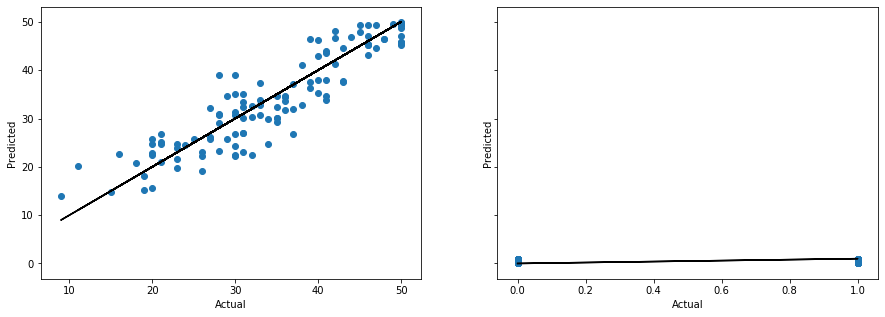

In [276]:
# Create figure and axes
fig, ax = plt.subplots(figsize = (15, 5), nrows = 1, ncols = 2, sharey = True)
pred = [s_reg_predictions, s_cla_predictions]
title = ['Ensemble Regression', 'Ensemble Classification']
test_set = [y_test_r, y_test_c] 
for i in range(2):
    ax[i].set_xlabel('Actual')
    ax[i].set_ylabel('Predicted')
    ax[i].plot(test_set[i], test_set[i], 'black')
    ax[i].scatter(test_set[i], pred[i])